# 1. Data Preparation

After downloading the selected database of ECG signals, a preprocessing stage was put in place to obtain an adequate organization of the data, extracting general information of each subject and specific characteristics of each ECG waveform to create a DataFrame with several features for further processing. 

In [43]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import seaborn as sns
from scipy import signal
%matplotlib inline

## 1.1 Signal pre-processing

Since there are relative few subjects, more data was obtained by dividing the signal into portions, assigning the correspondet information to create more rows with unique values. 

In [44]:
# Getting the ECG signals from original files

general_directory = os.path.join(os.getcwd(), 'ecg-id-database-1.0.0')
entries = os.listdir(general_directory)

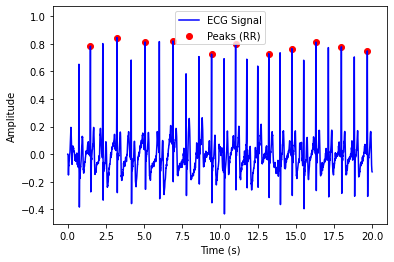

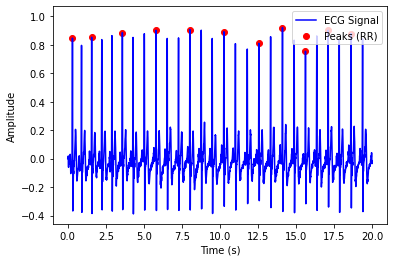

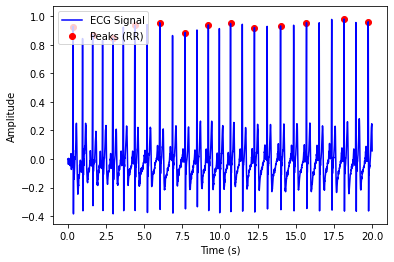

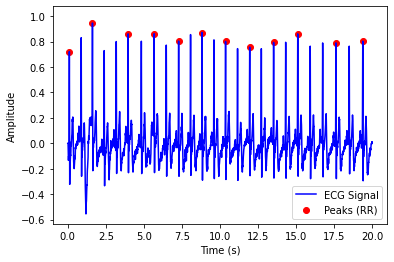

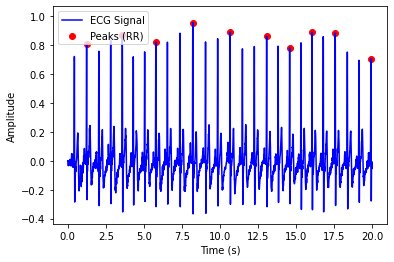

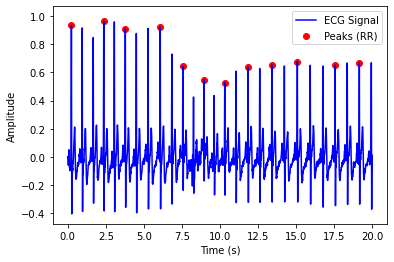

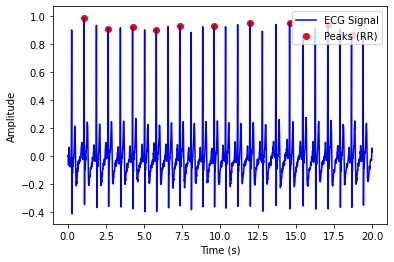

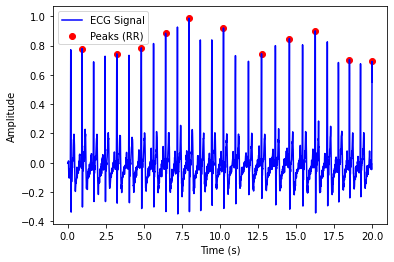

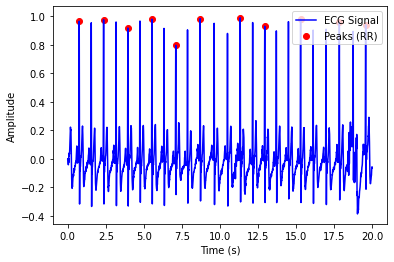

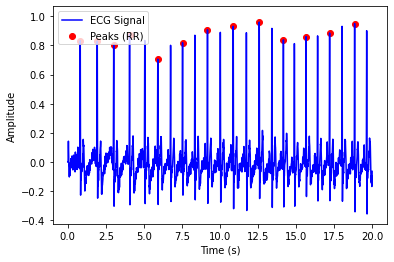

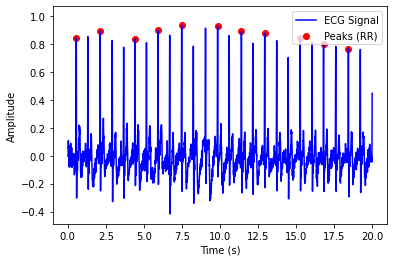

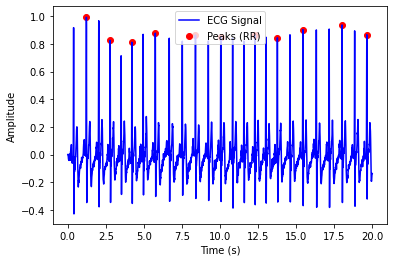

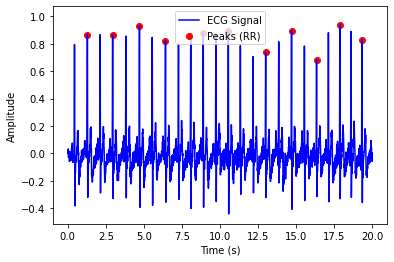

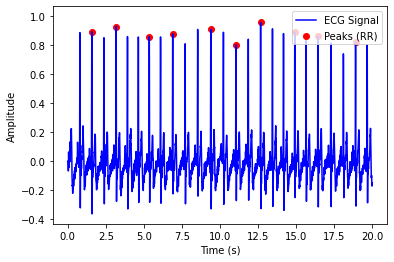

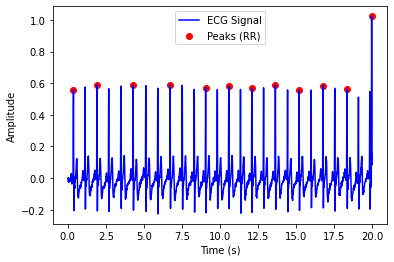

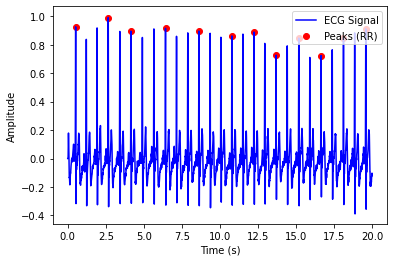

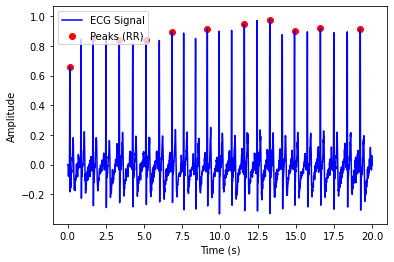

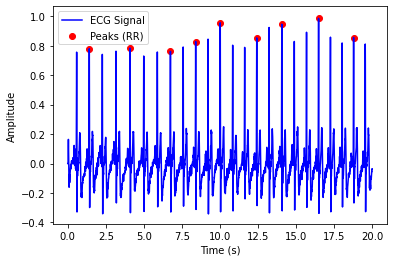

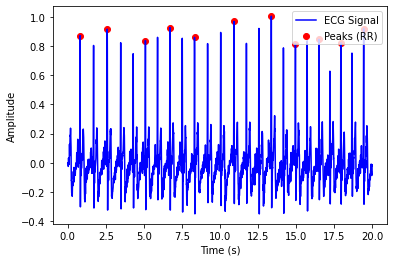

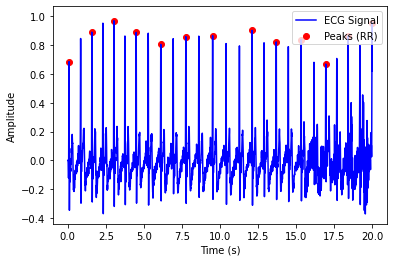

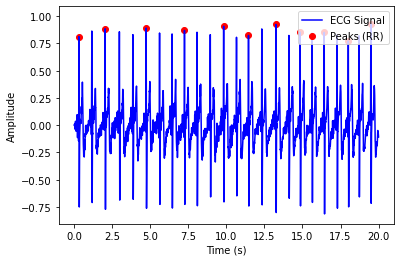

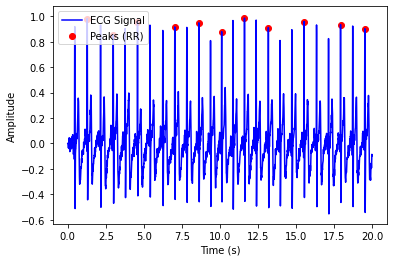

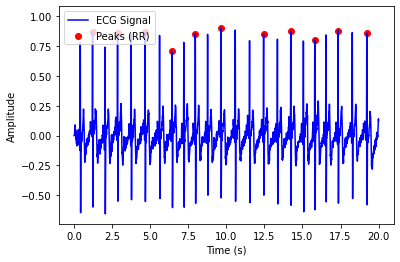

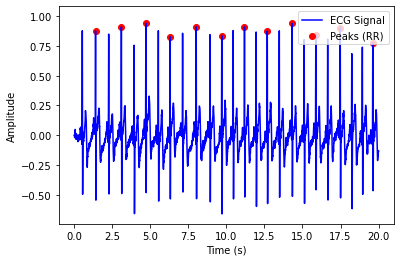

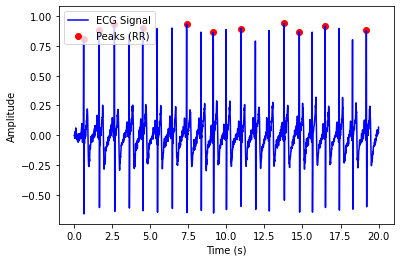

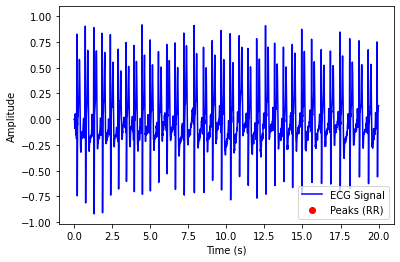

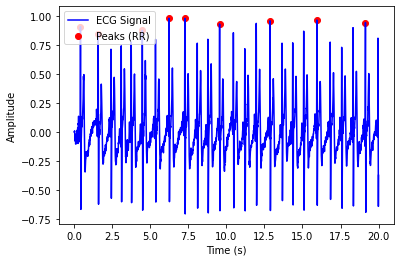

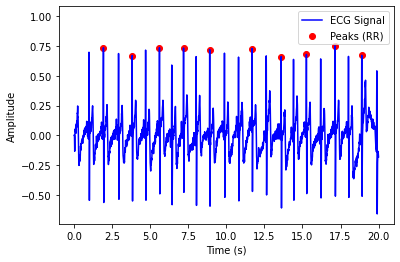

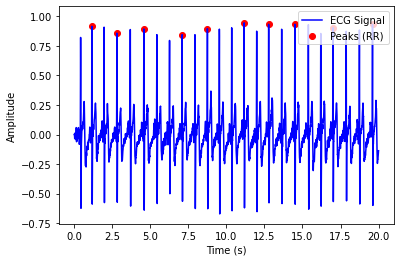

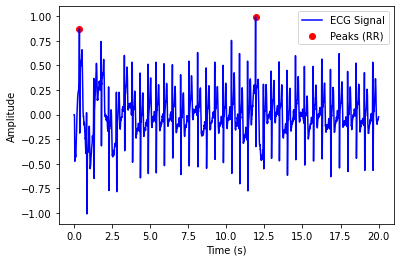

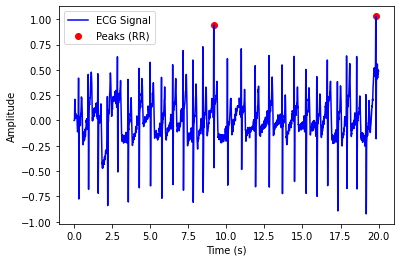

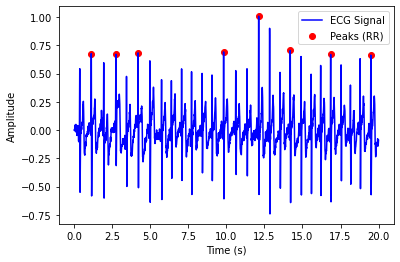

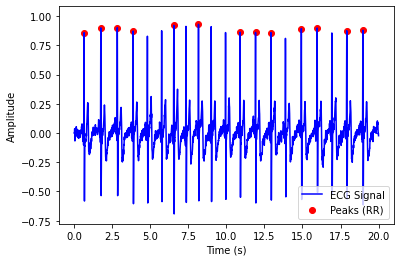

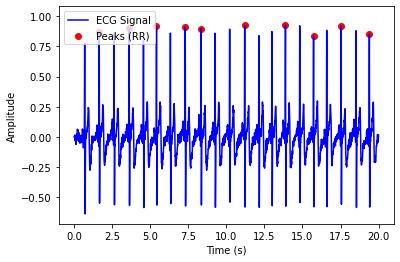

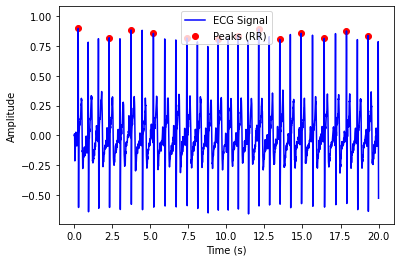

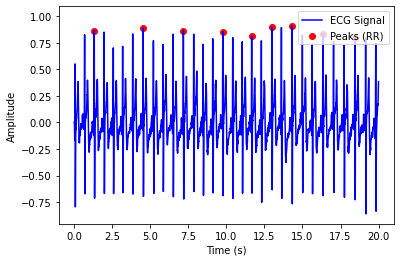

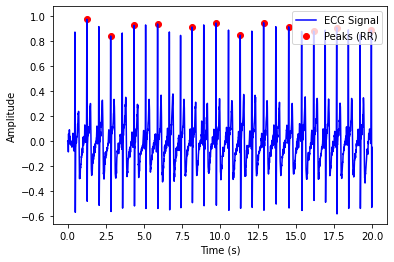

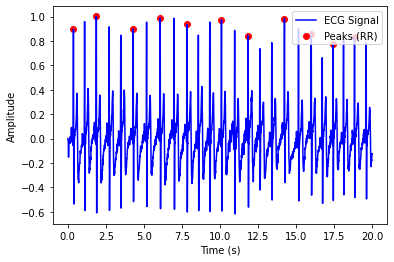

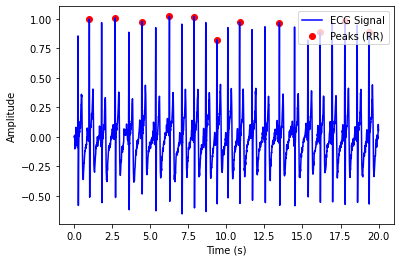

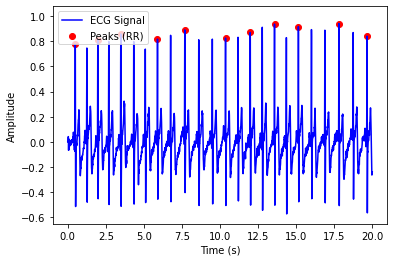

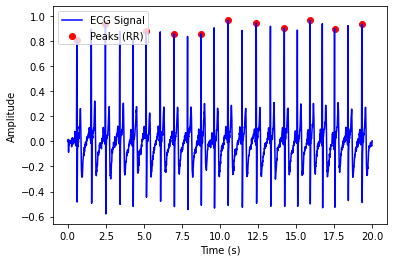

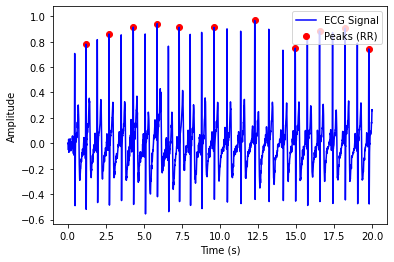

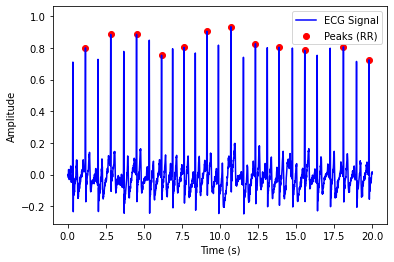

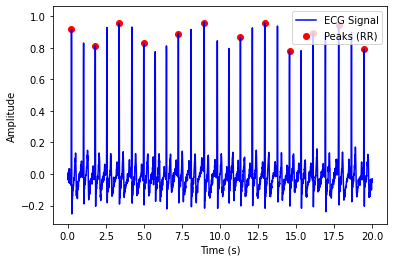

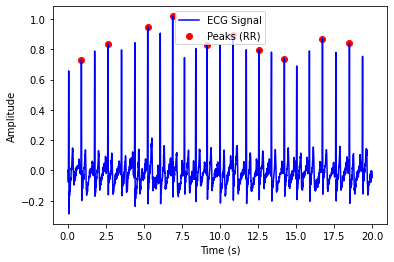

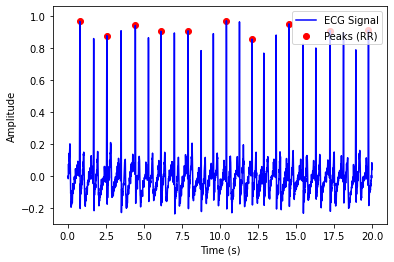

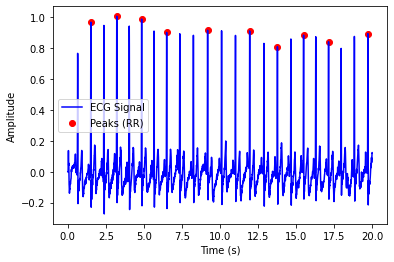

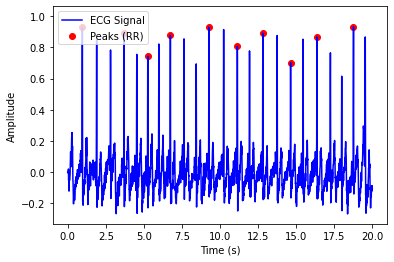

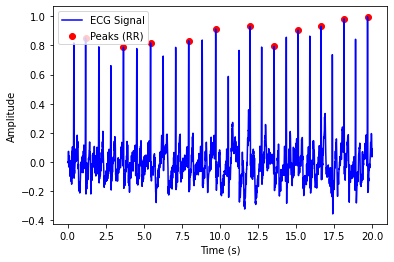

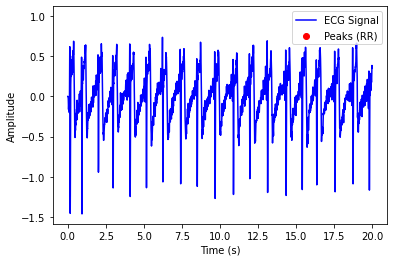

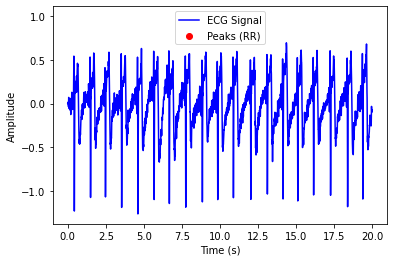

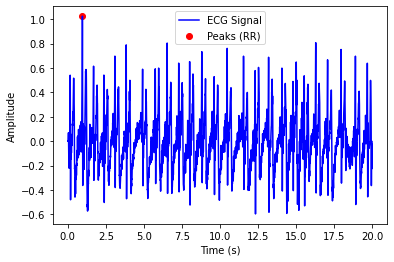

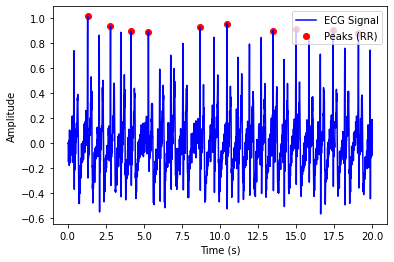

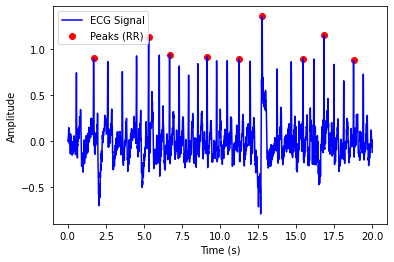

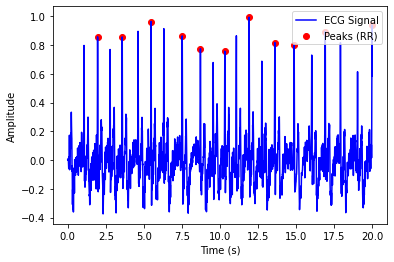

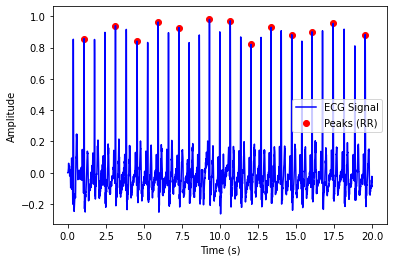

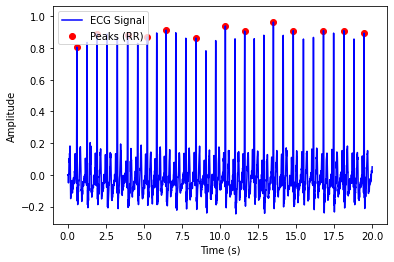

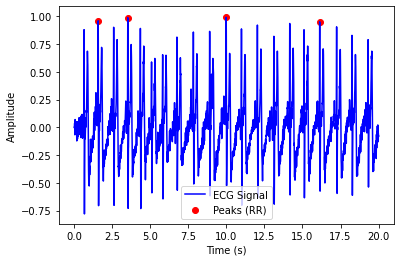

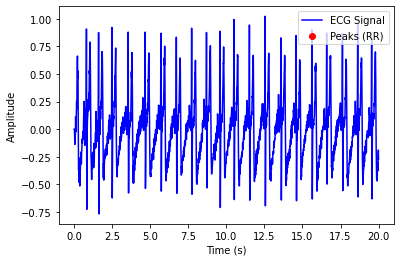

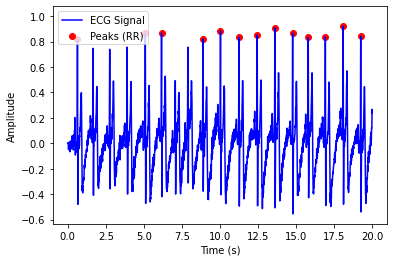

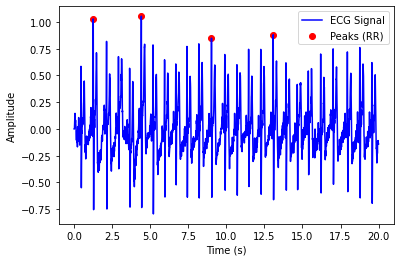

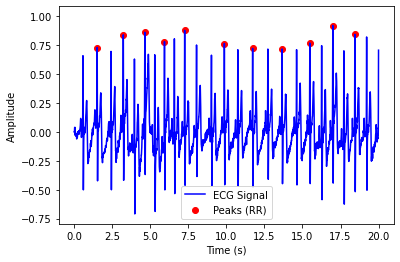

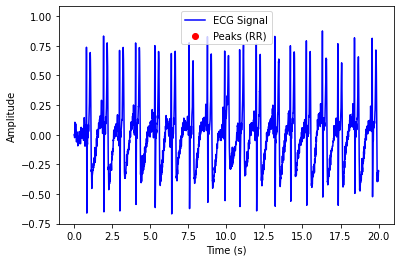

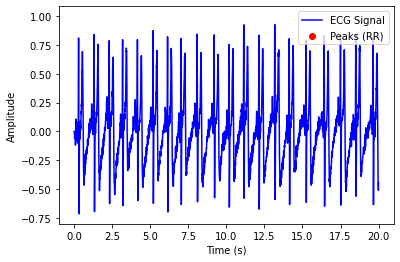

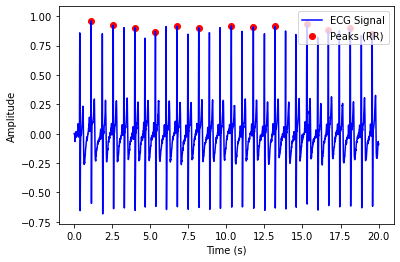

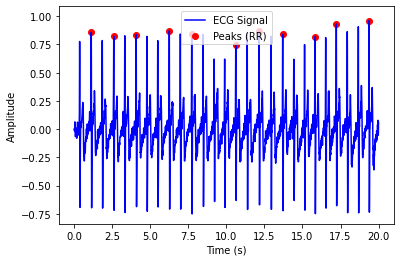

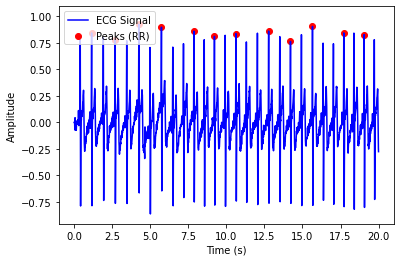

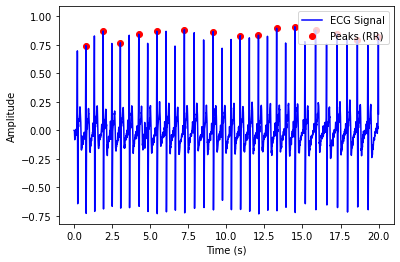

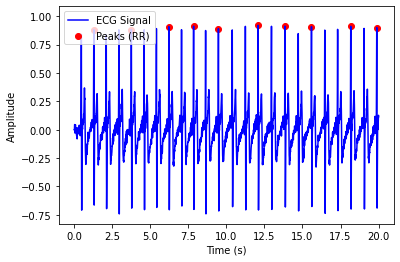

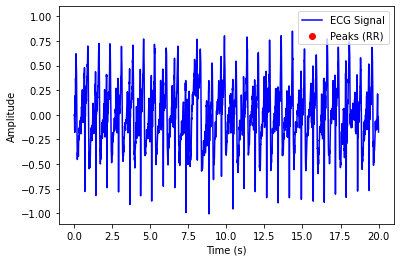

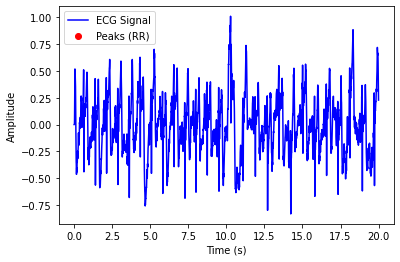

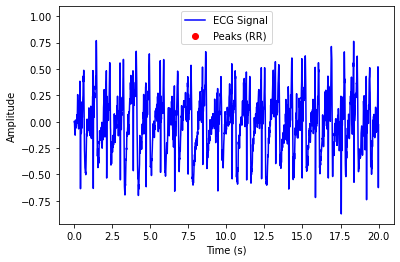

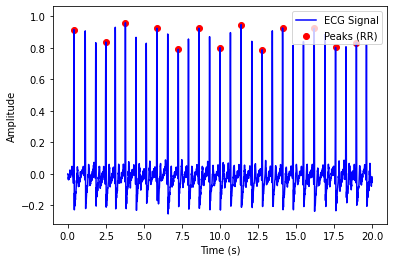

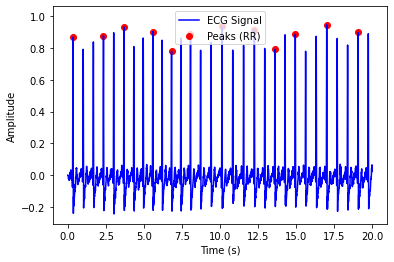

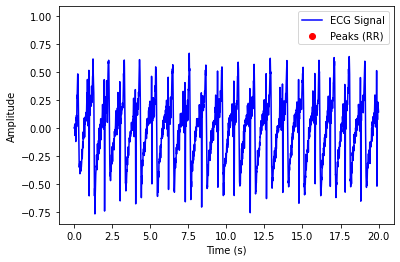

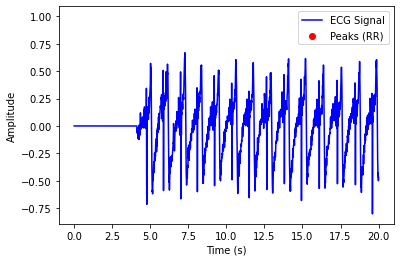

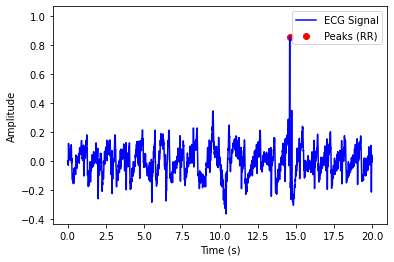

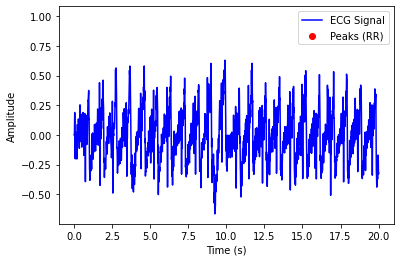

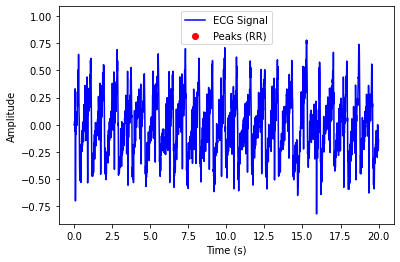

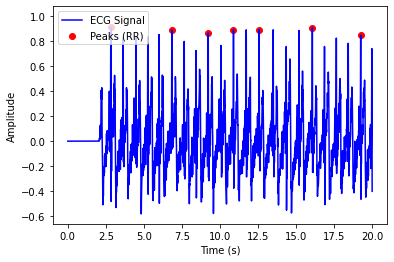

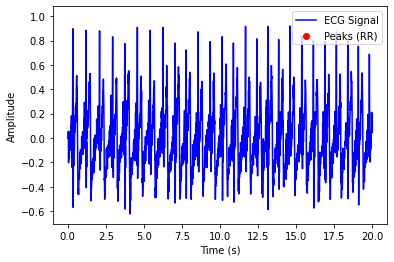

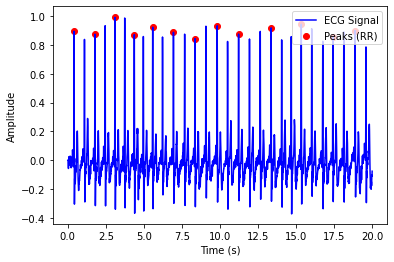

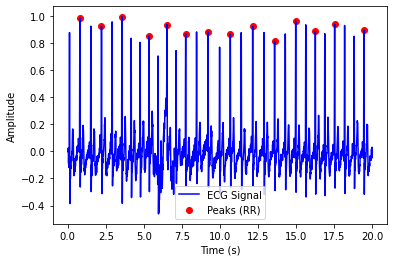

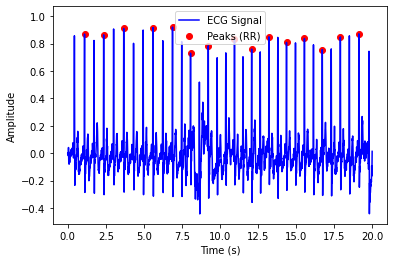

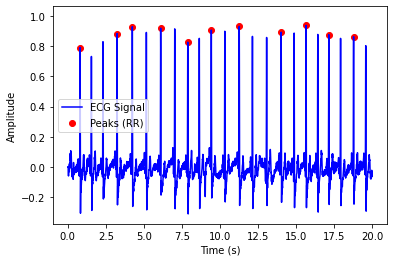

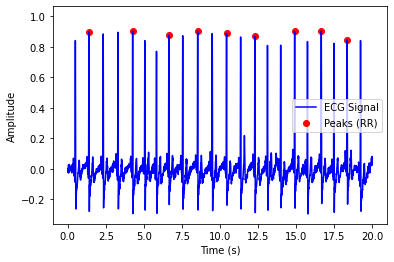

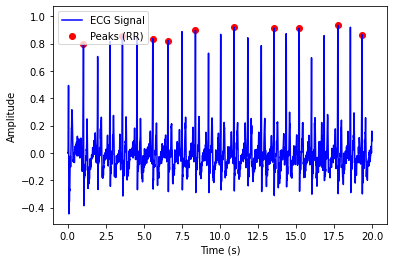

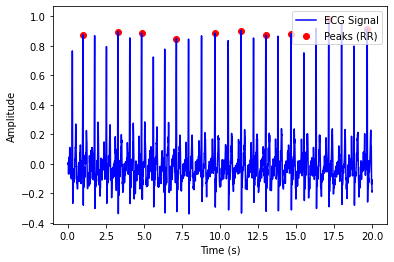

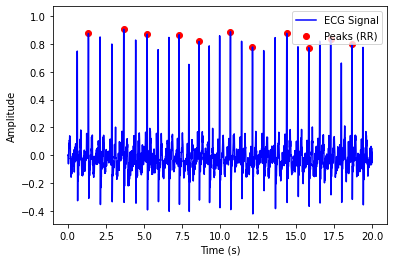

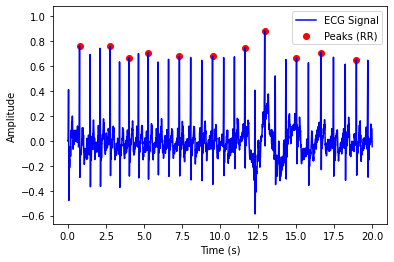

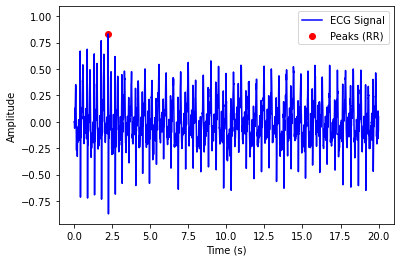

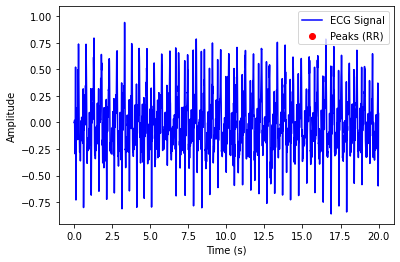

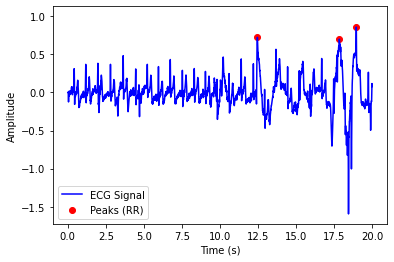

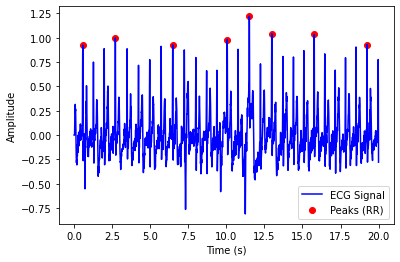

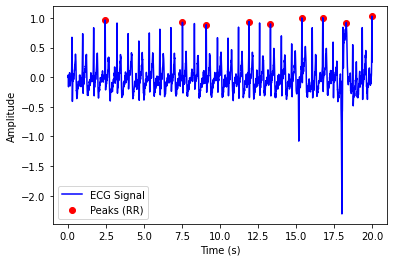

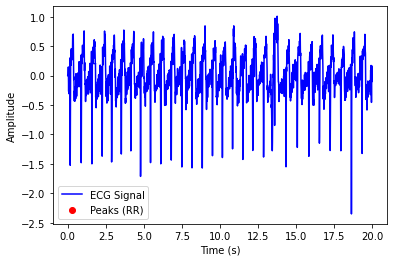

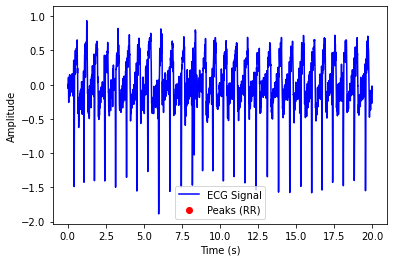

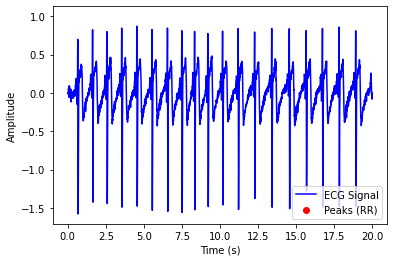

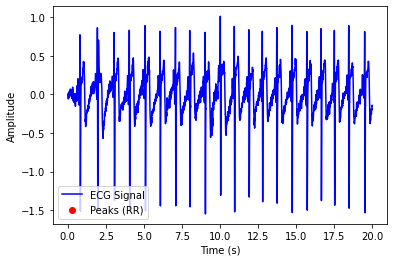

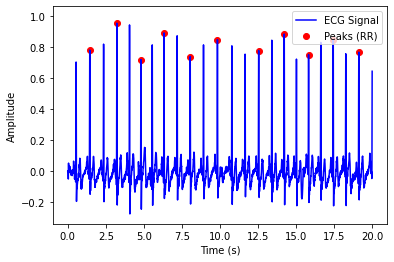

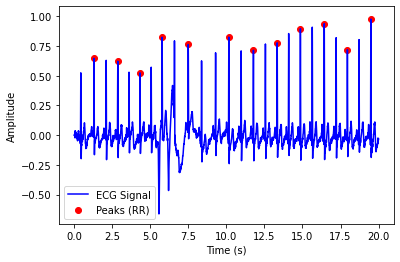

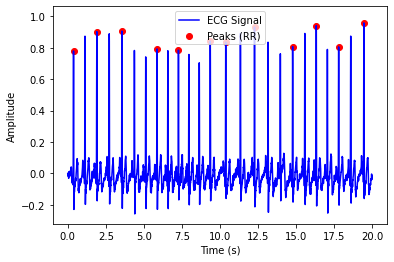

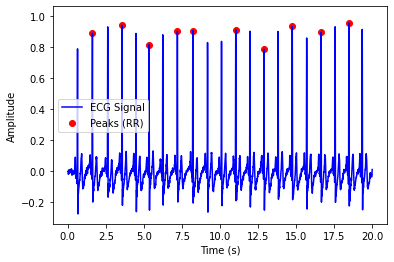

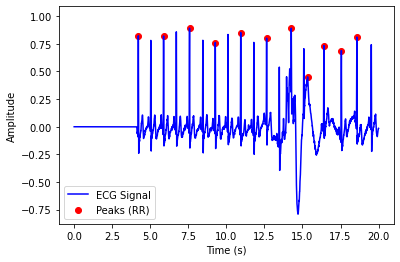

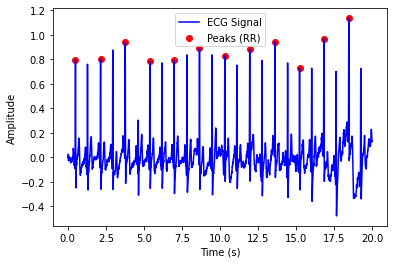

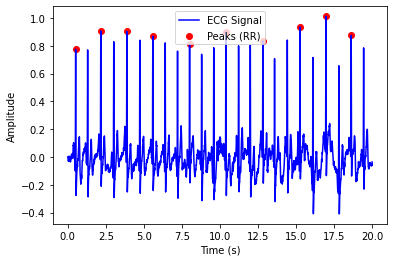

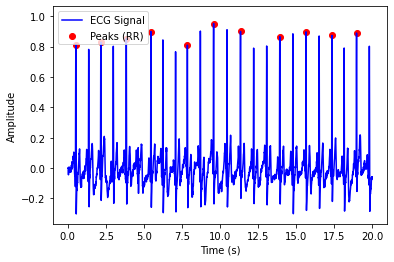

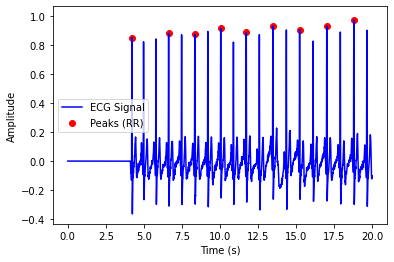

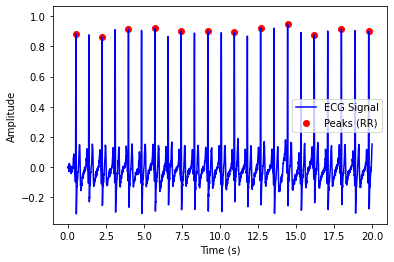

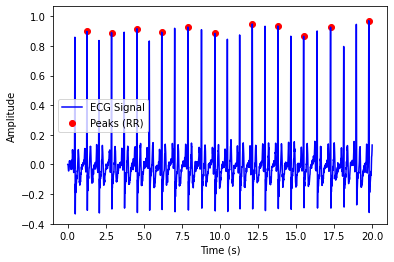

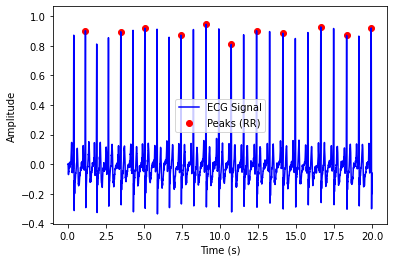

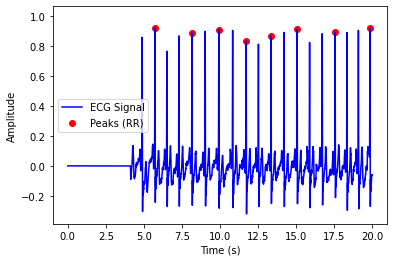

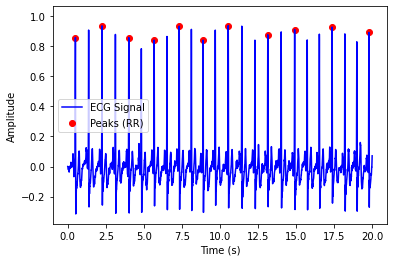

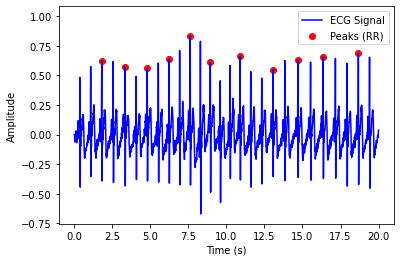

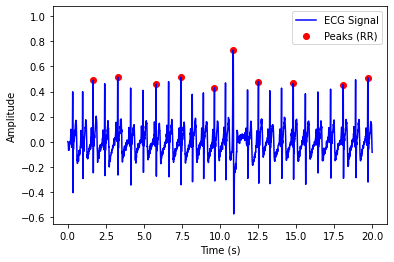

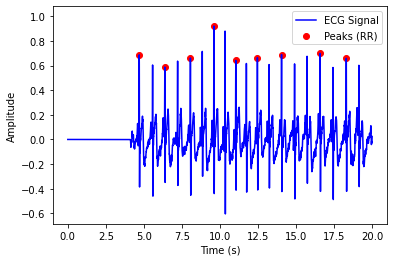

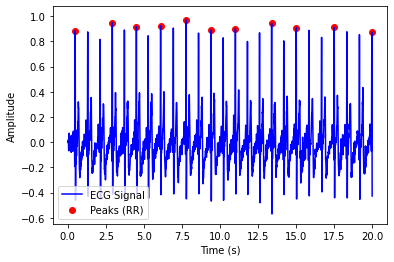

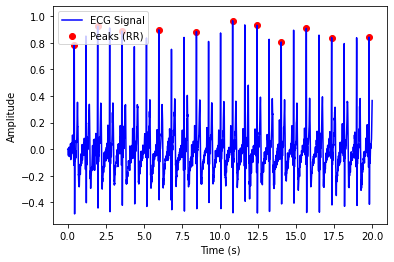

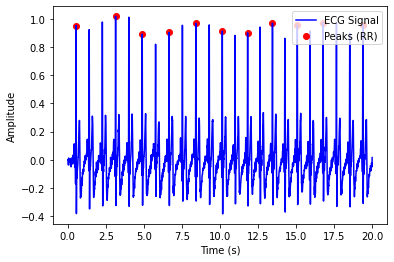

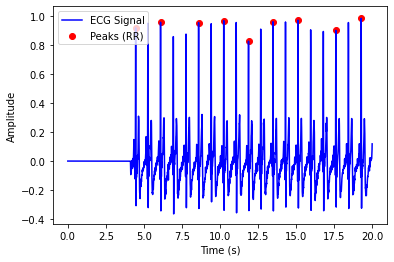

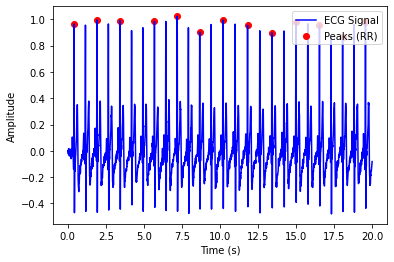

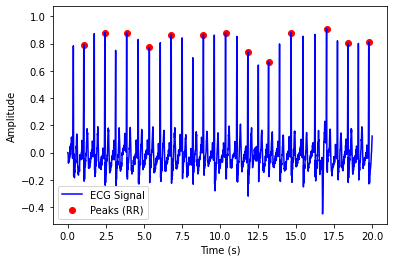

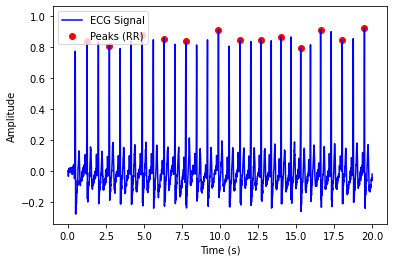

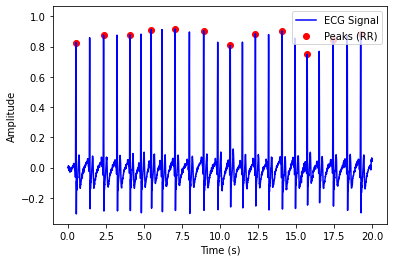

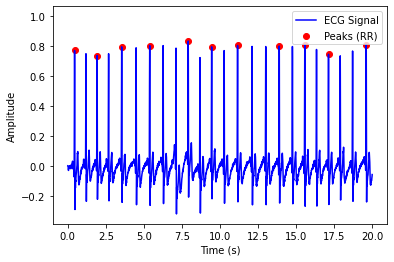

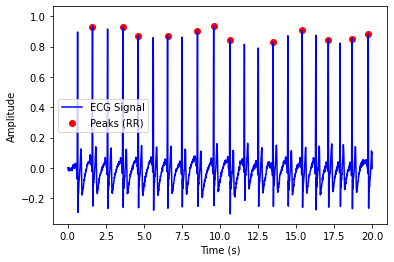

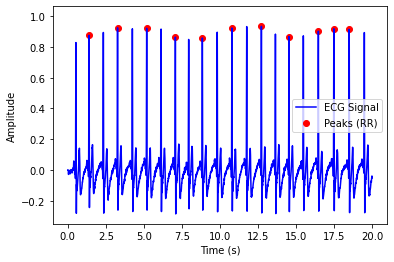

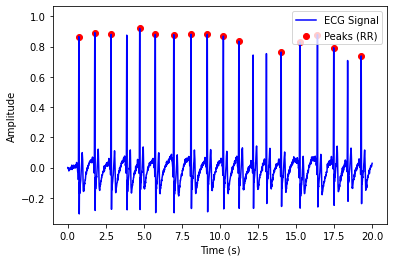

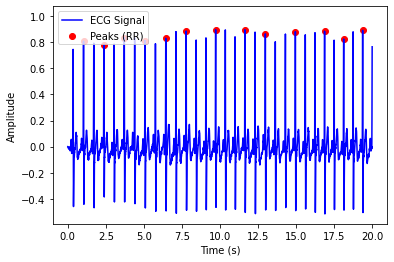

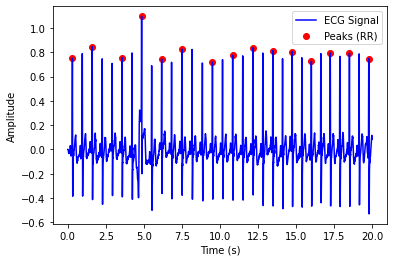

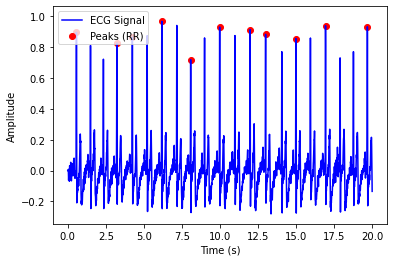

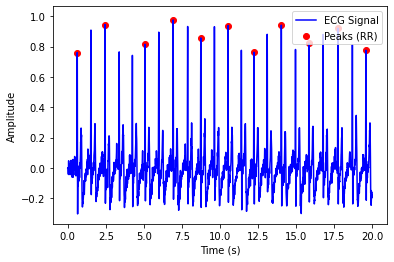

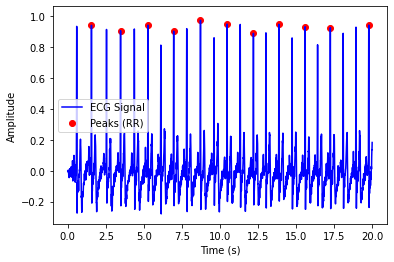

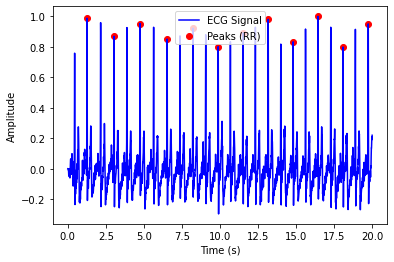

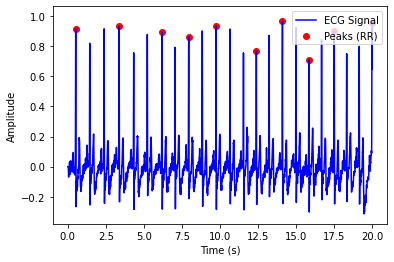

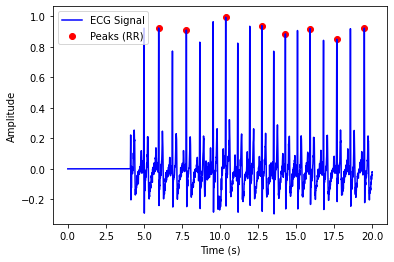

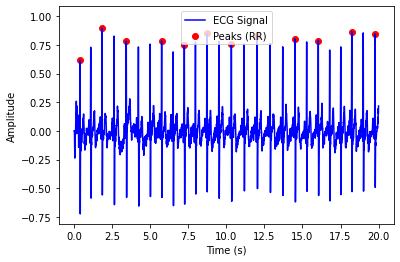

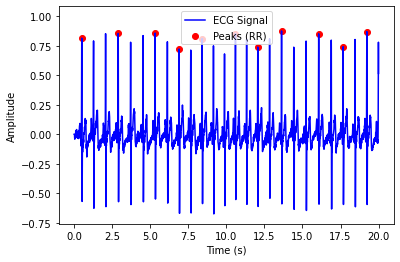

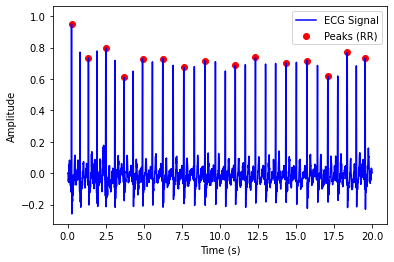

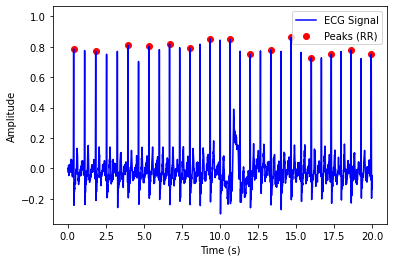

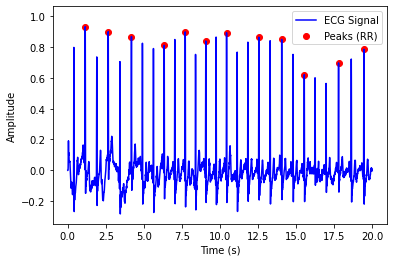

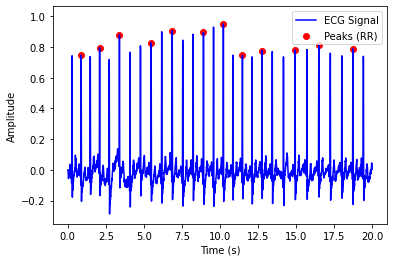

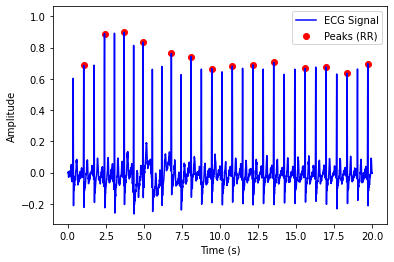

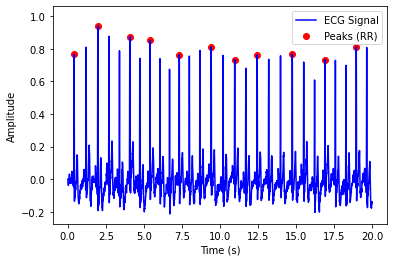

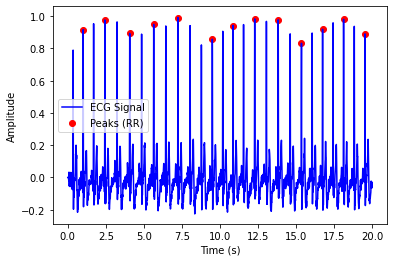

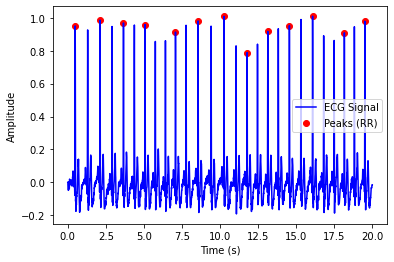

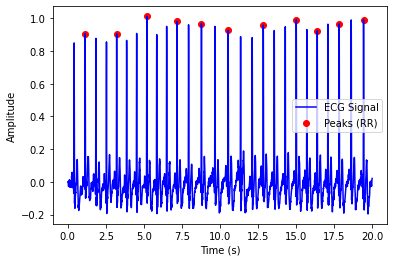

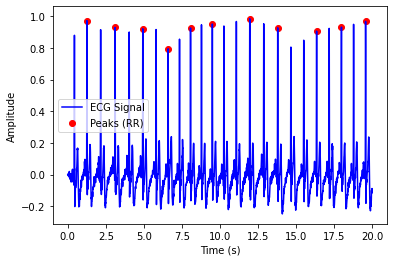

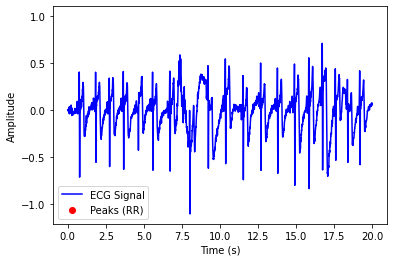

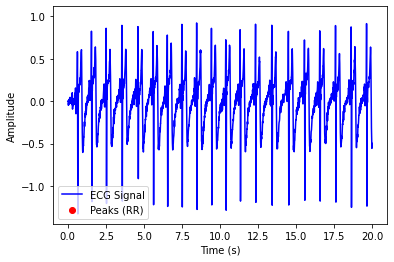

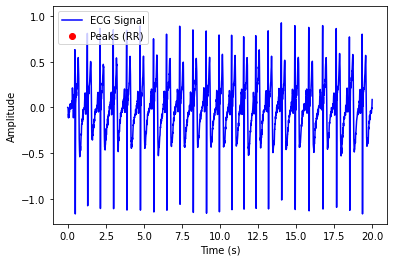

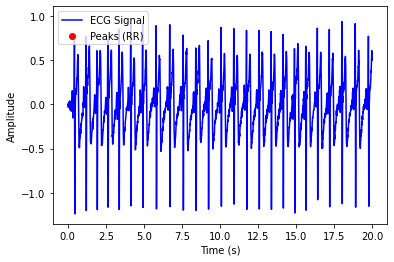

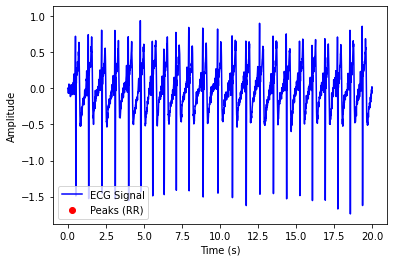

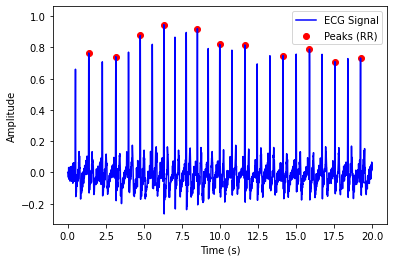

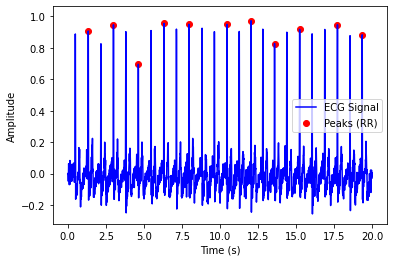

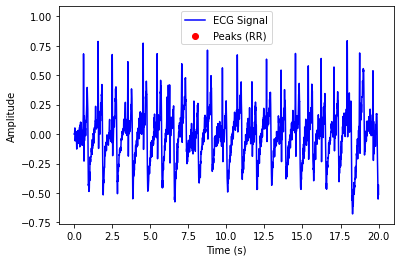

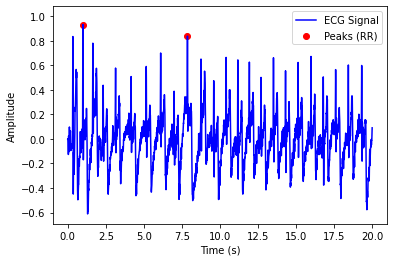

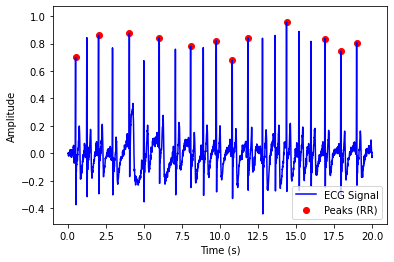

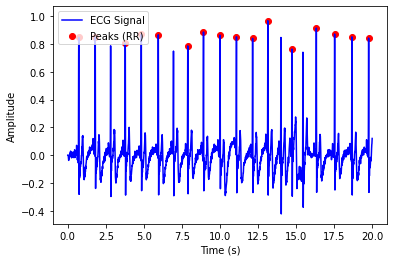

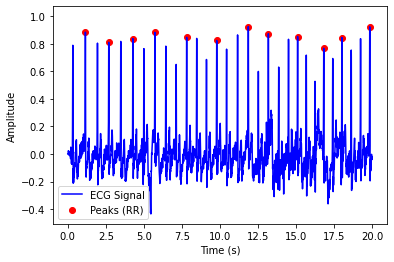

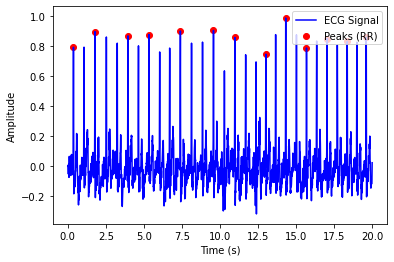

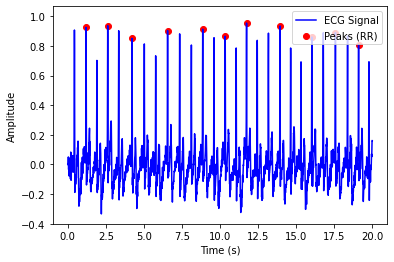

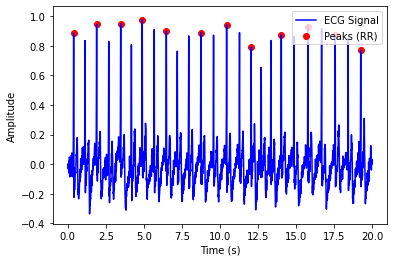

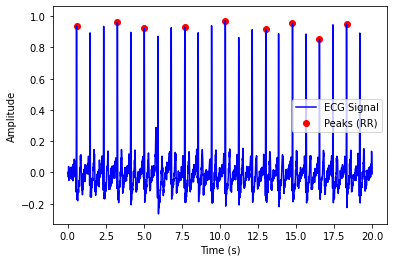

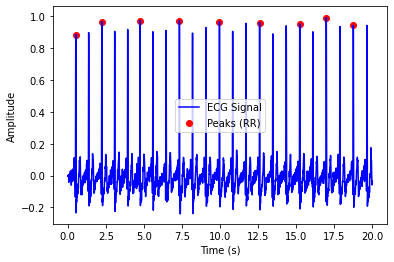

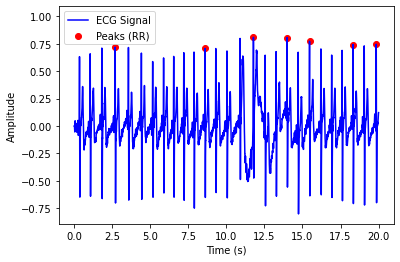

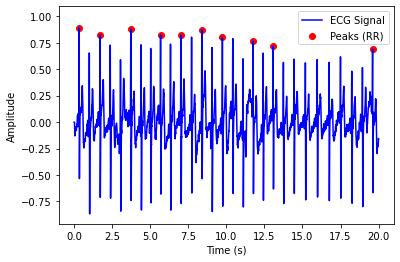

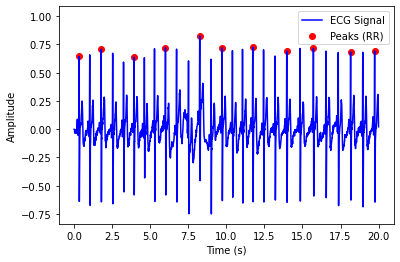

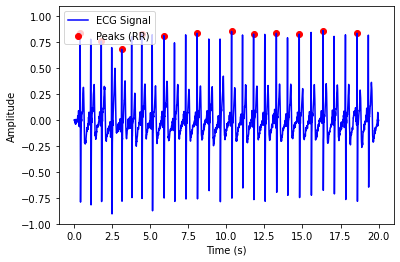

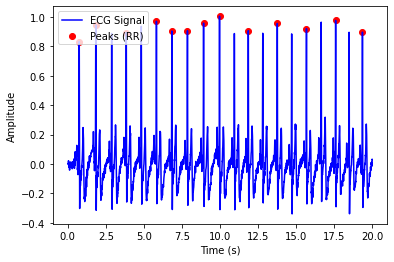

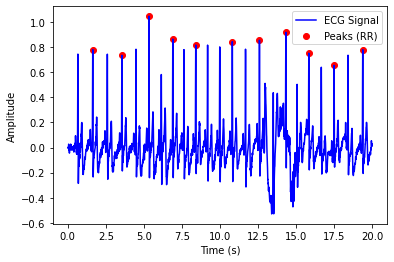

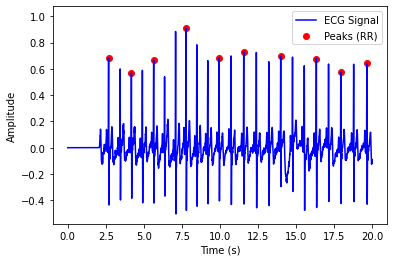

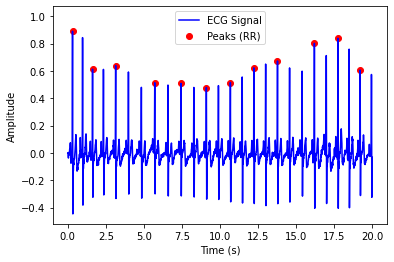

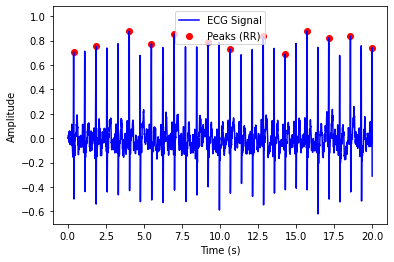

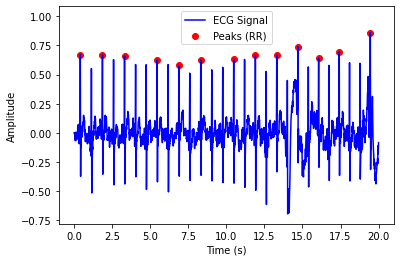

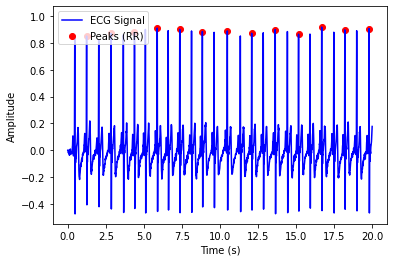

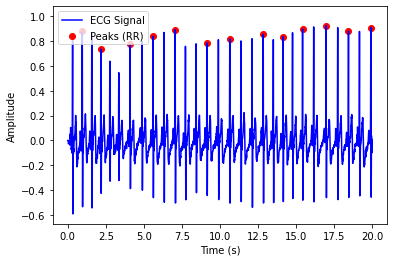

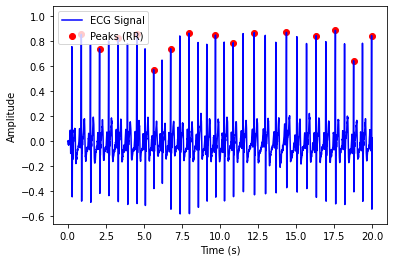

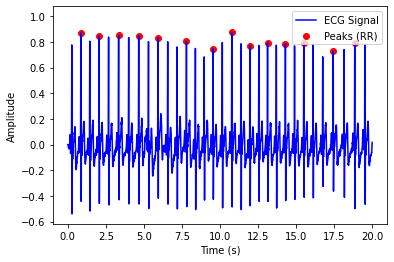

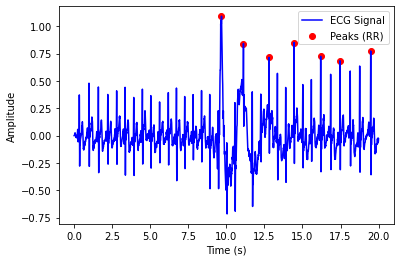

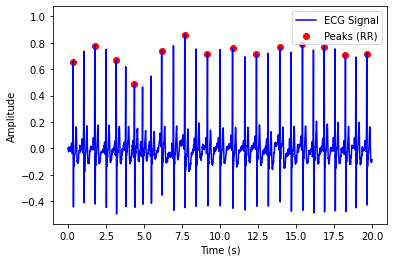

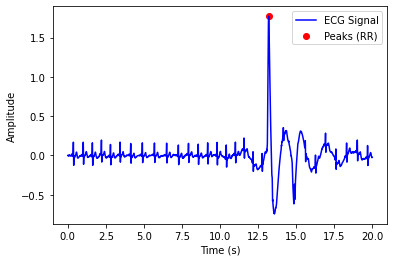

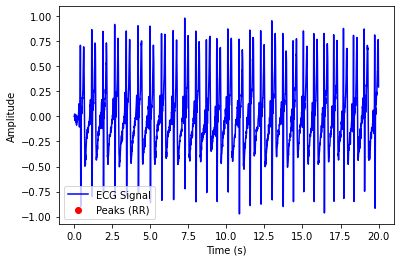

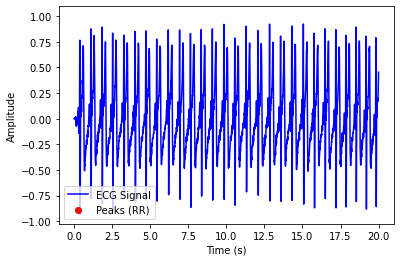

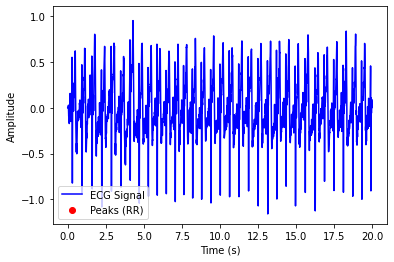

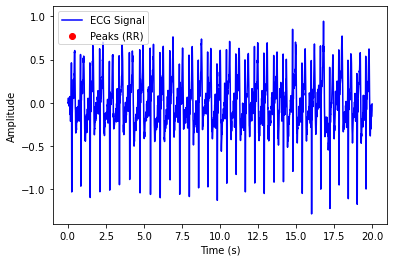

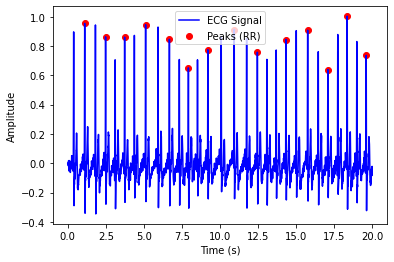

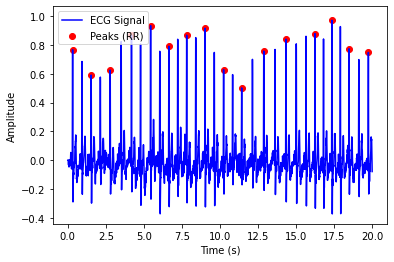

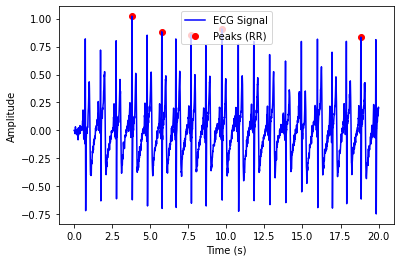

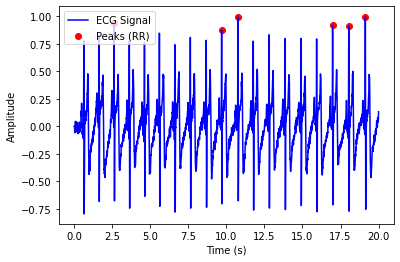

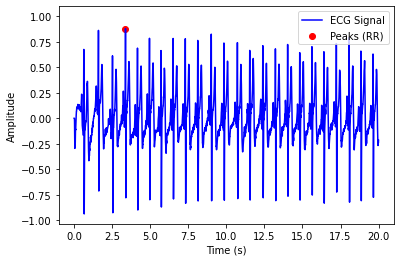

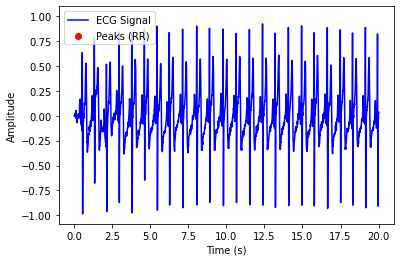

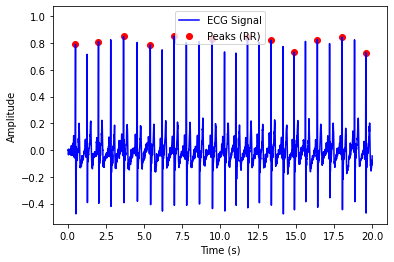

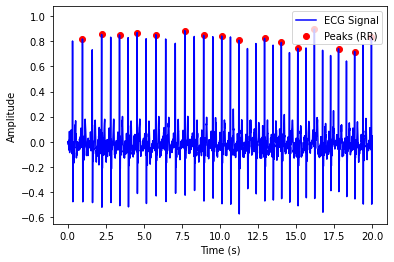

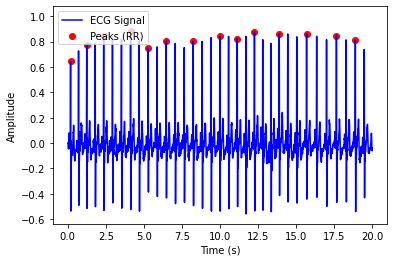

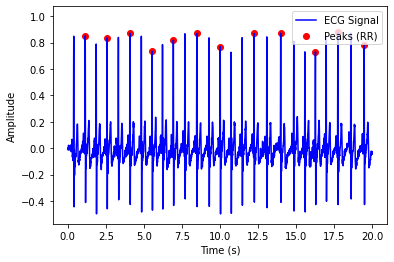

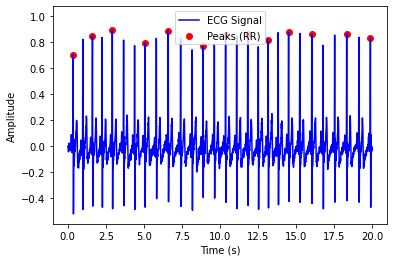

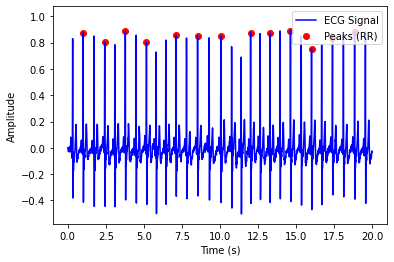

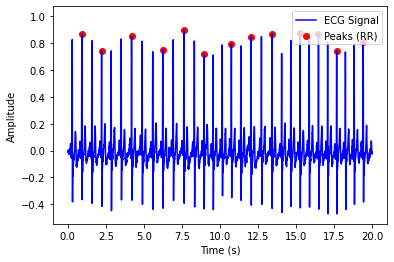

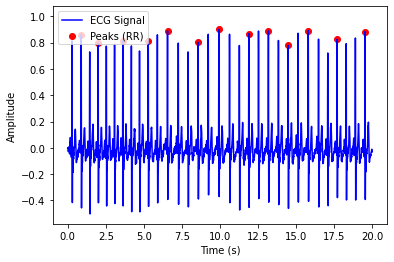

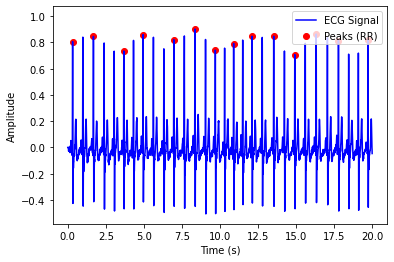

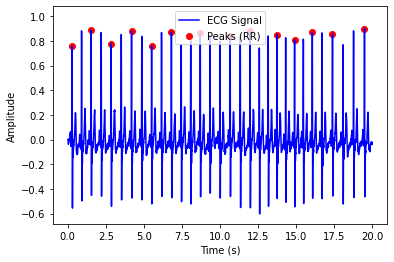

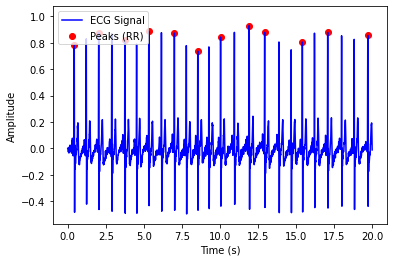

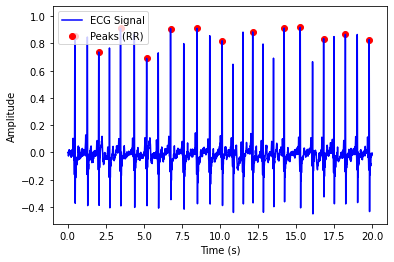

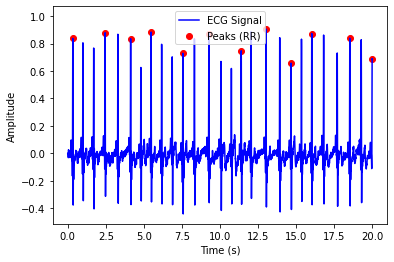

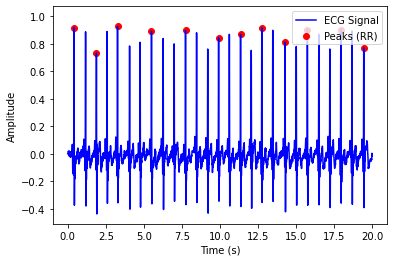

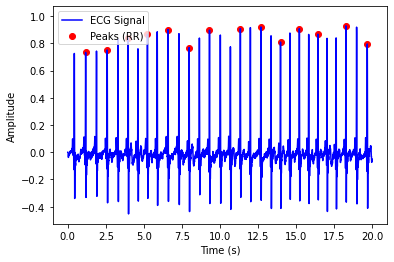

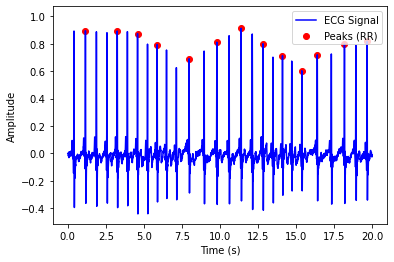

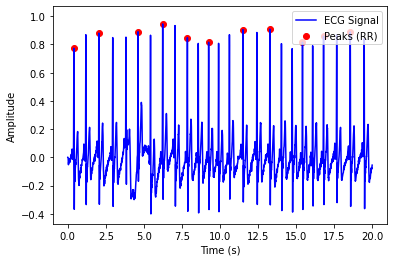

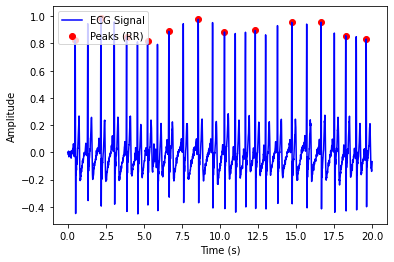

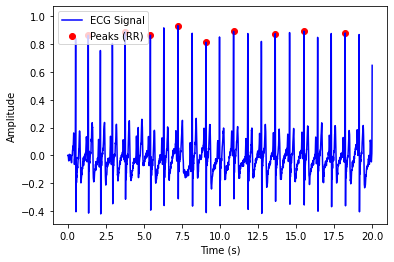

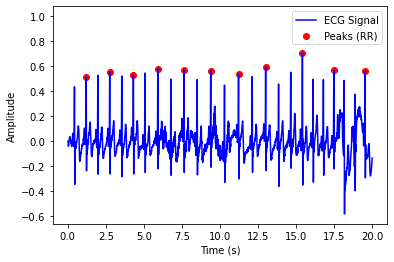

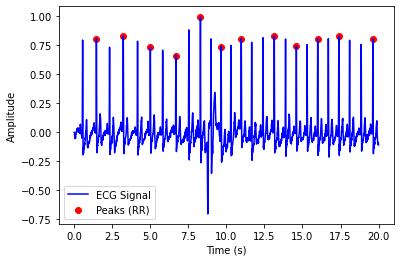

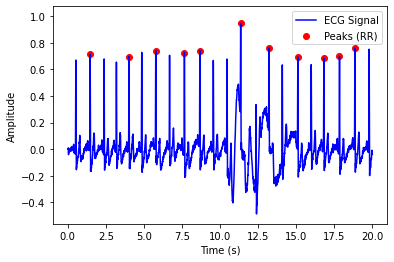

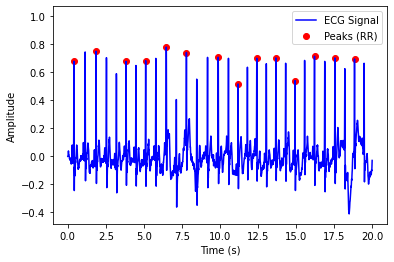

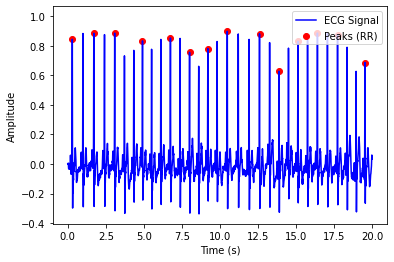

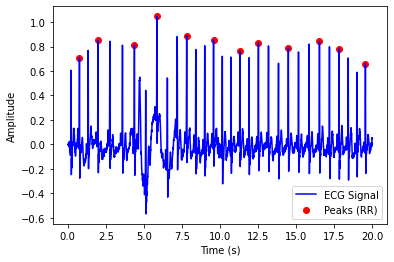

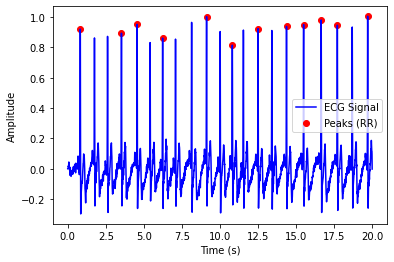

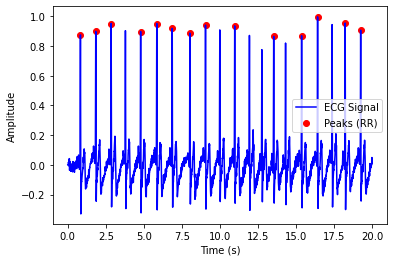

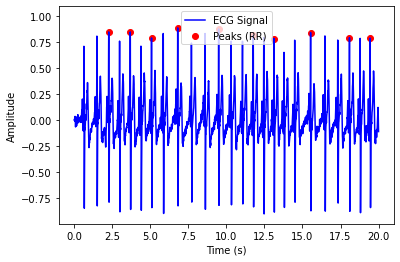

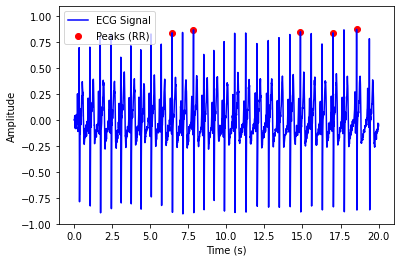

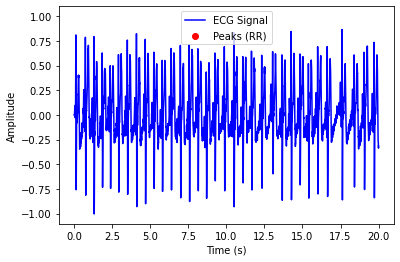

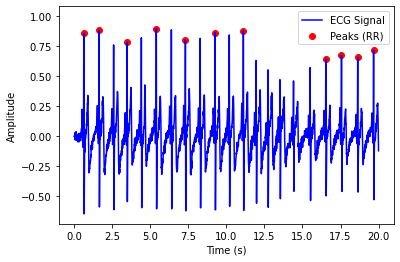

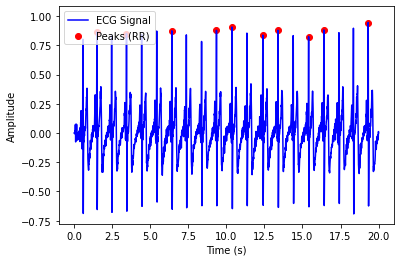

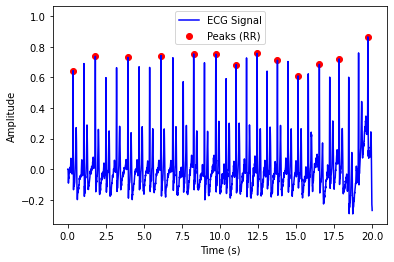

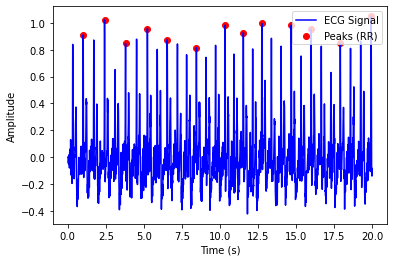

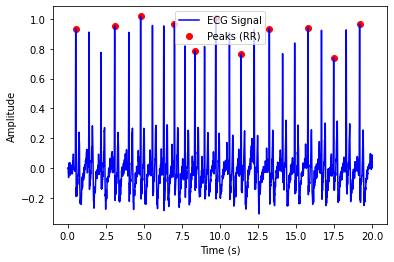

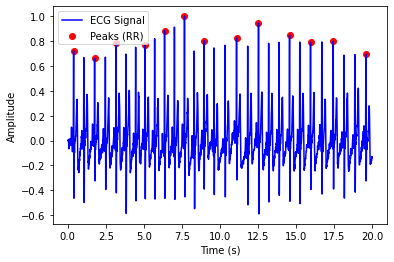

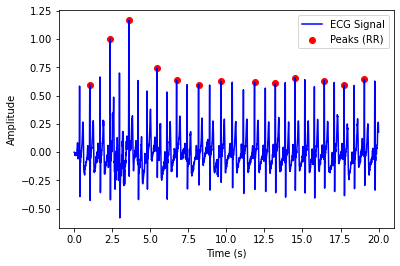

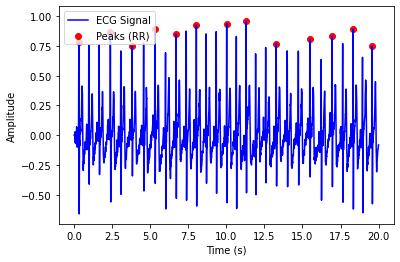

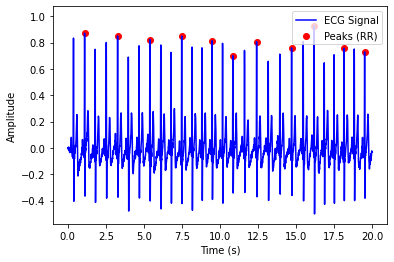

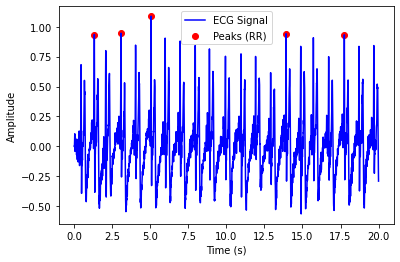

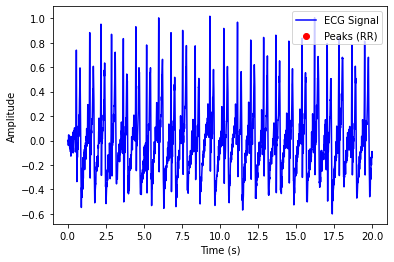

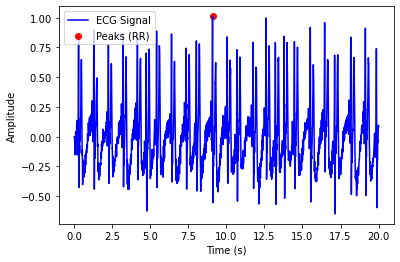

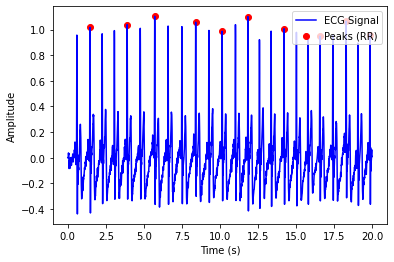

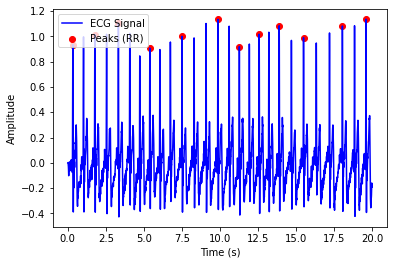

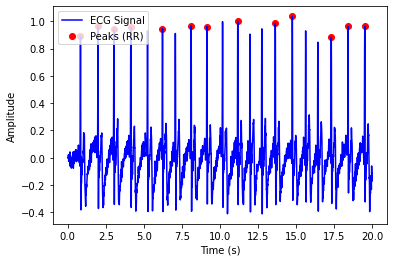

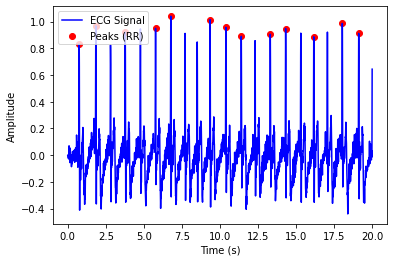

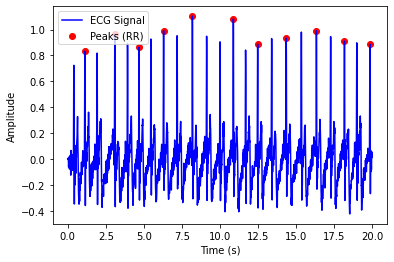

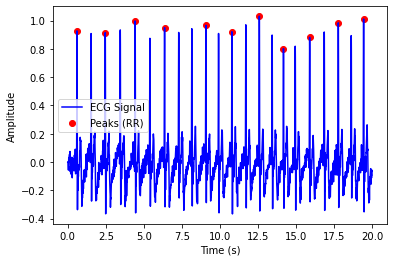

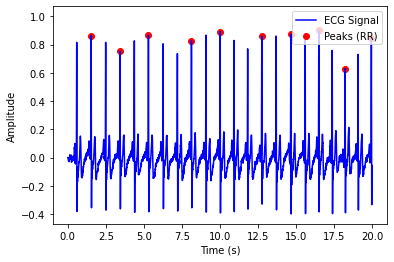

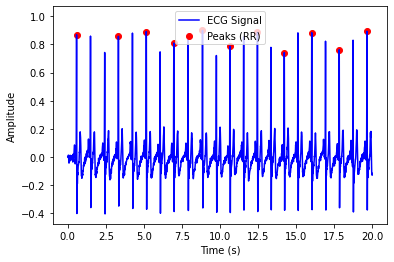

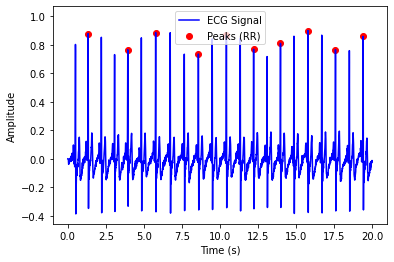

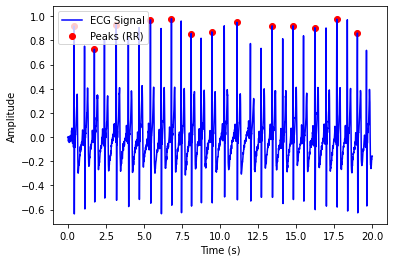

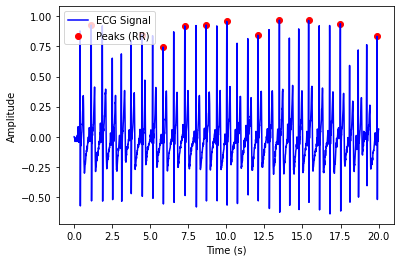

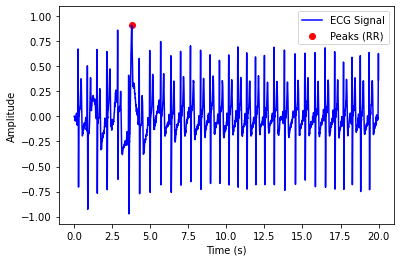

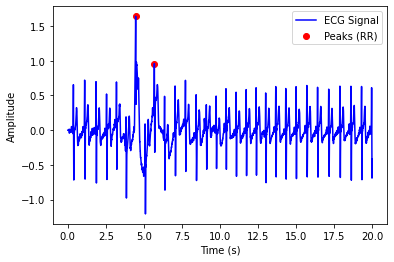

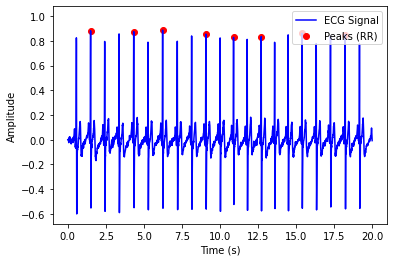

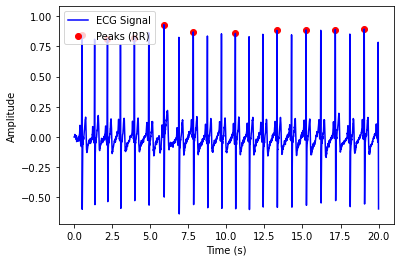

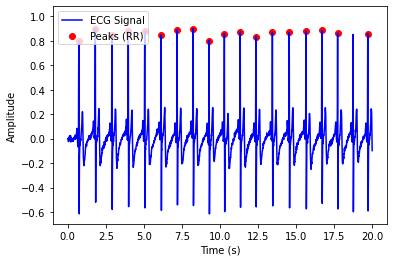

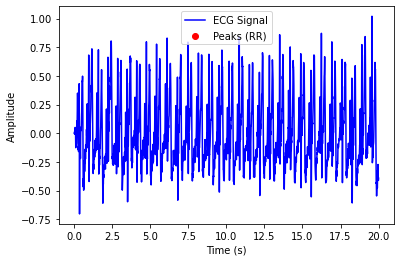

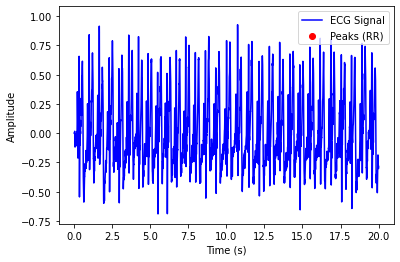

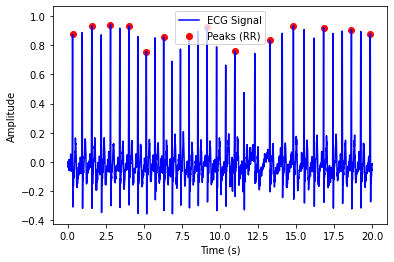

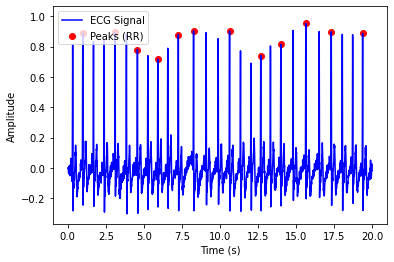

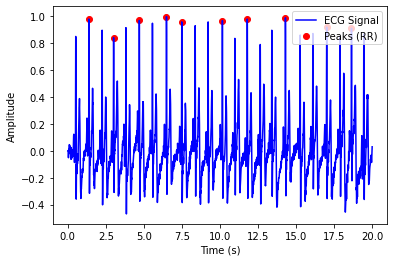

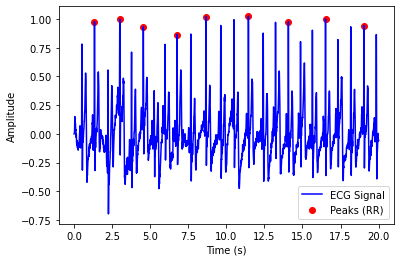

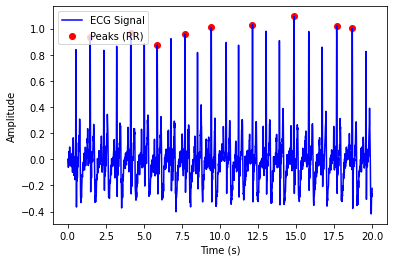

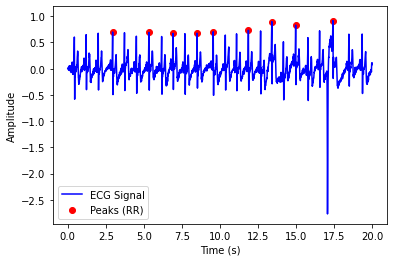

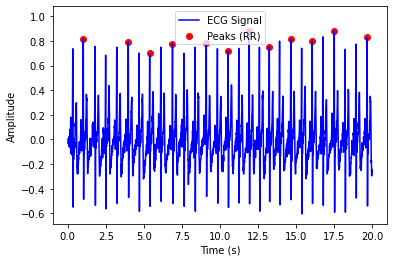

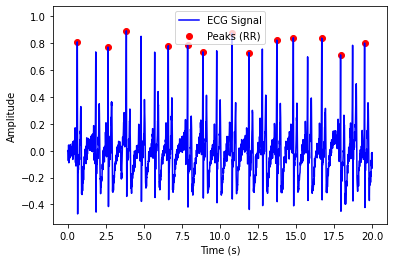

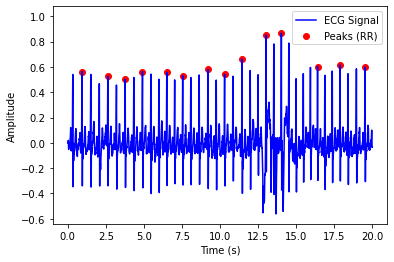

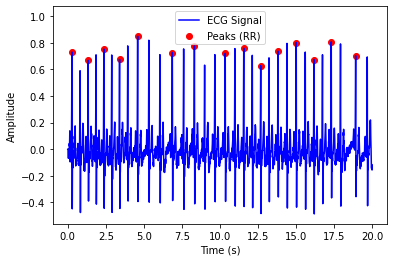

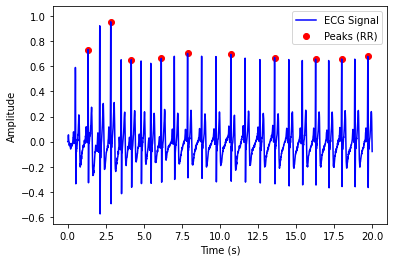

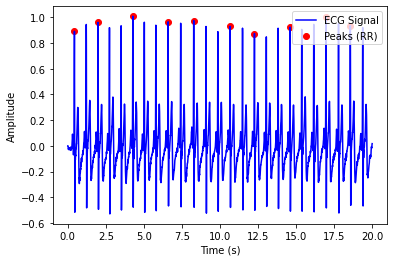

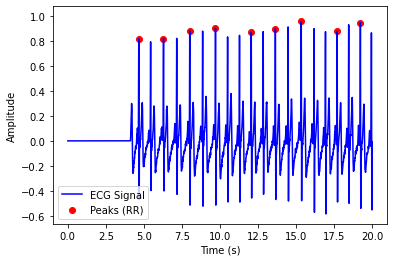

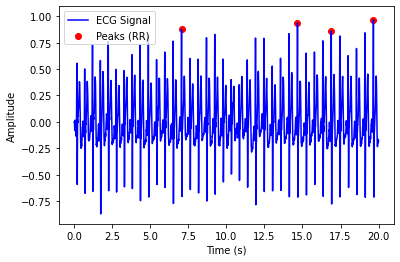

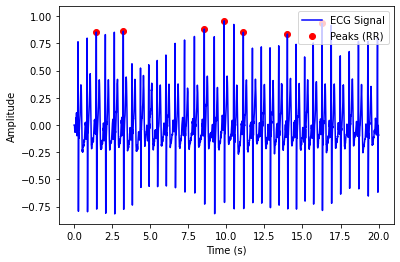

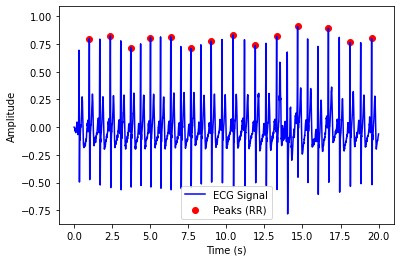

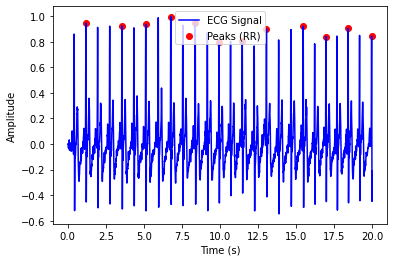

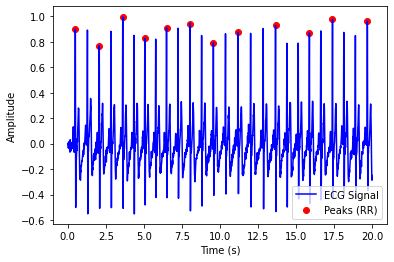

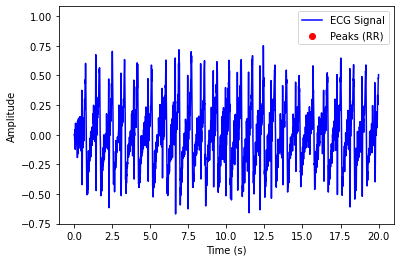

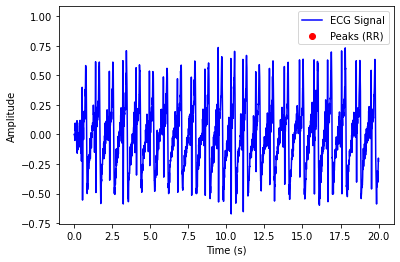

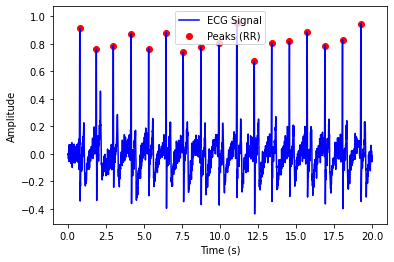

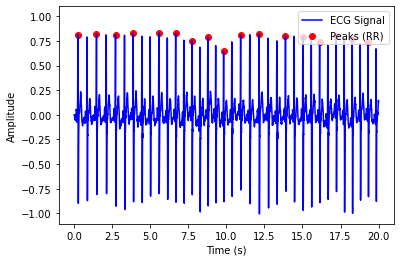

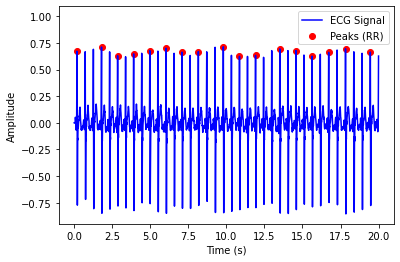

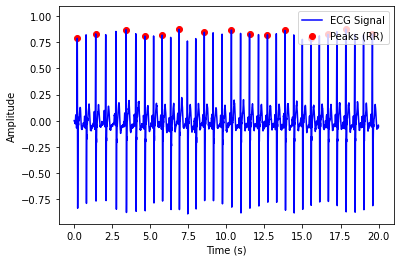

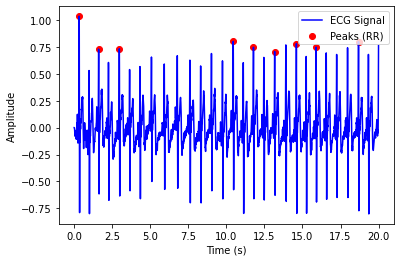

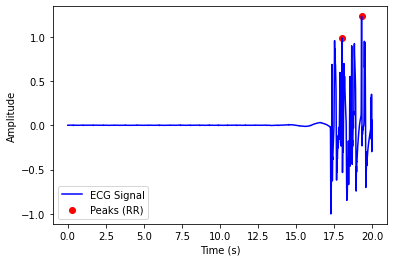

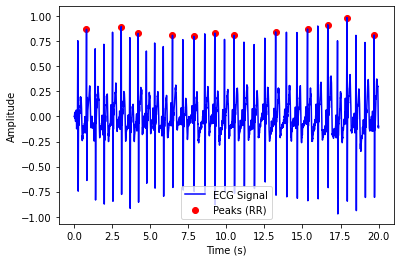

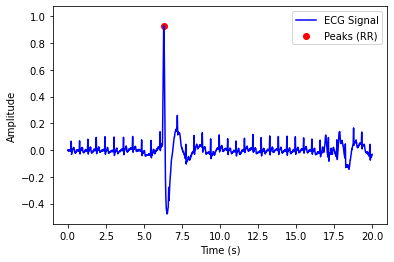

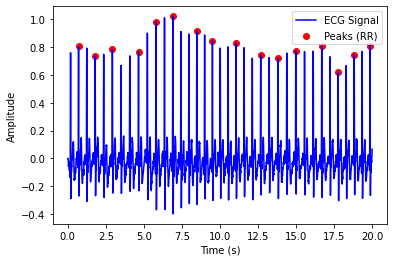

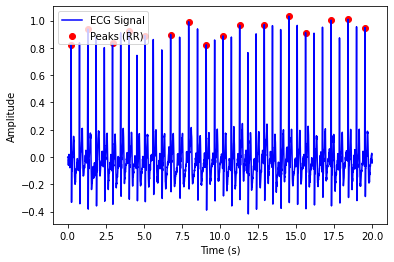

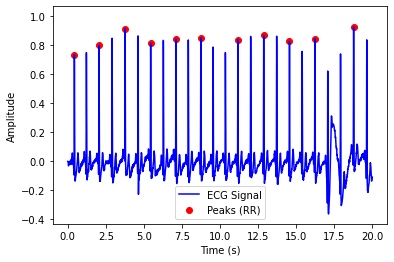

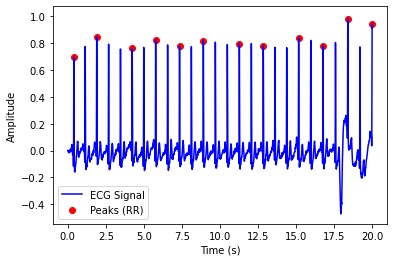

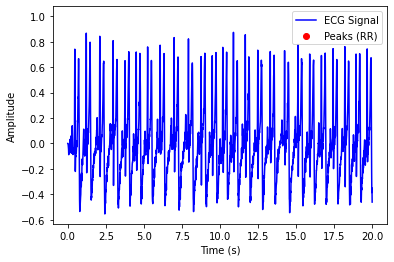

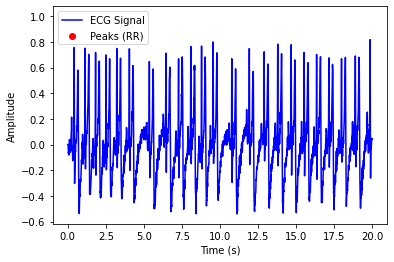

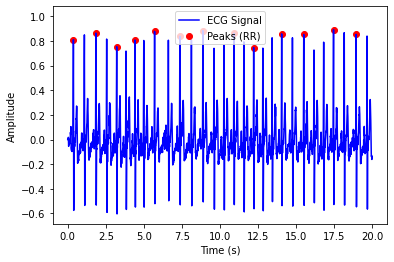

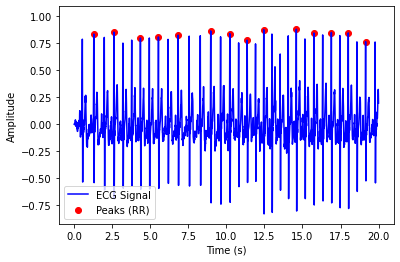

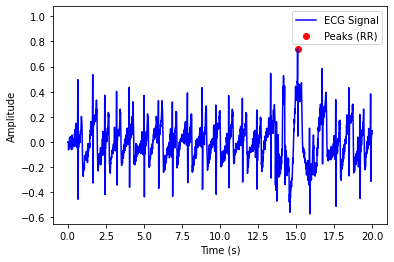

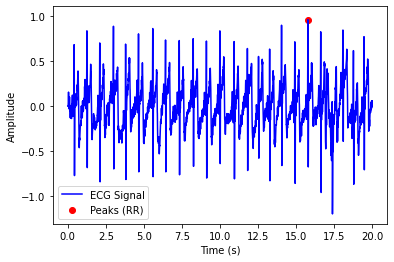

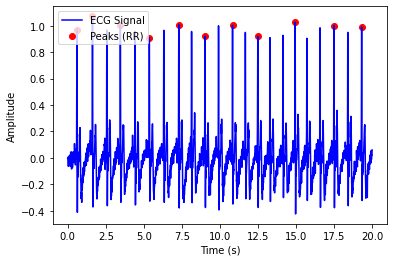

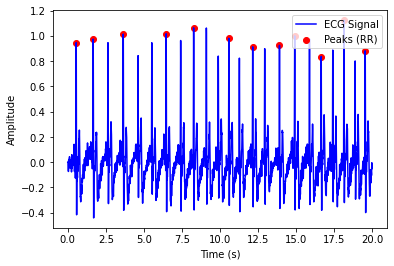

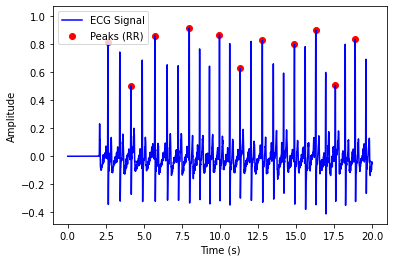

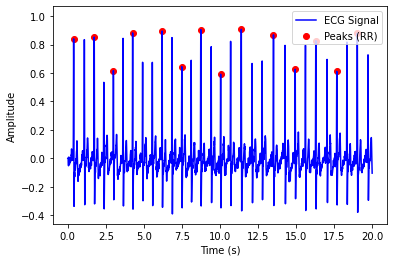

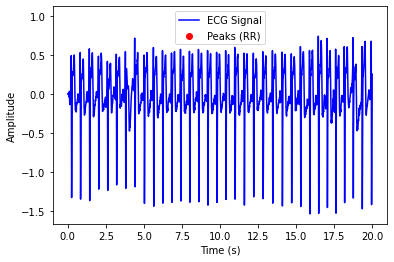

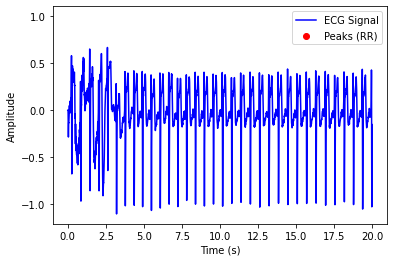

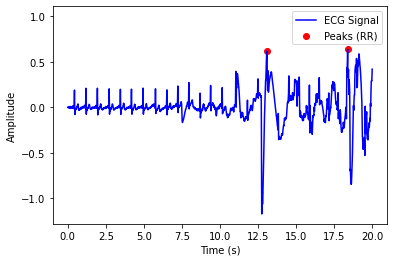

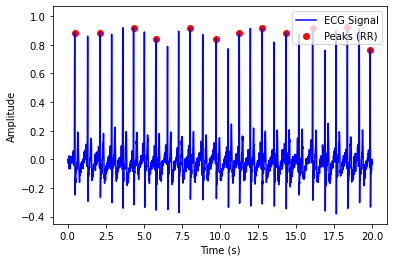

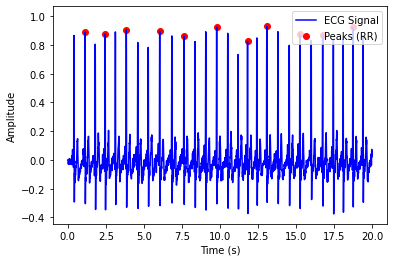

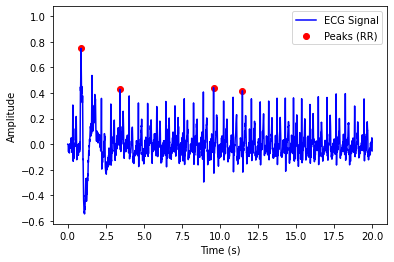

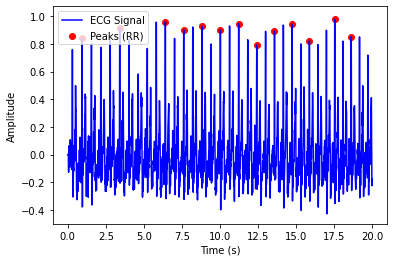

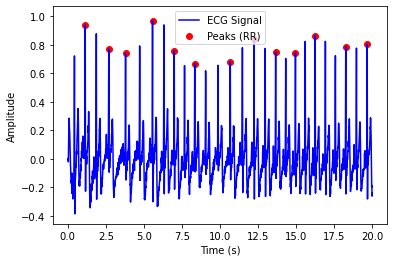

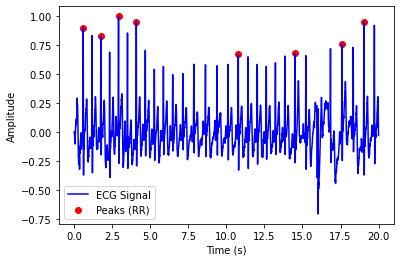

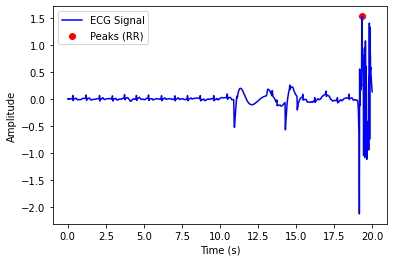

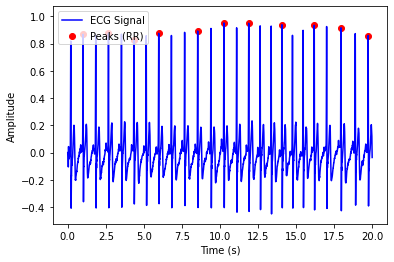

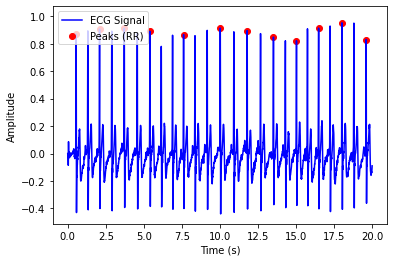

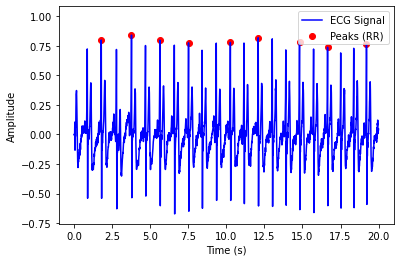

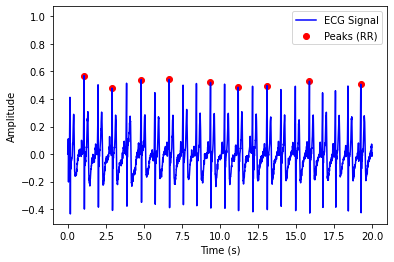

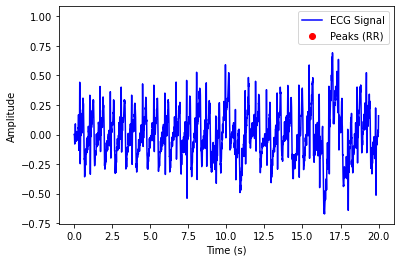

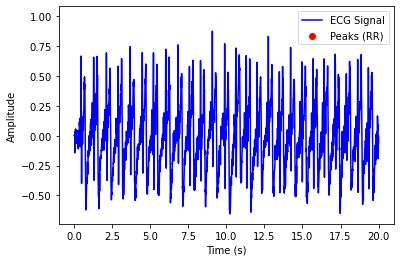

In [47]:
# Extracting relevant information and creating basic ECG based features

fs = 500 # Sampling frequency indicated by the publisher of the database
subject, age, gender, RR, ecg_mean, ecg_std, ecg_var, ecg_median, ecg_samples = [], [], [], [], [], [], [], [], []
def butter_lowpass(cutoff, fs, order=8):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a =signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a
for folder in entries:
    if "Person_" in folder:
             
        info_targetPattern = os.path.join(general_directory, folder, '*.hea')
        info_files = glob.glob(info_targetPattern)
        
        for ecg_info in info_files:
            with open(ecg_info) as f:
                subject_info = int(folder.replace("Person_","", 1))
                
                # Extracting demographic information
                lines = [line.rstrip() for line in f]
                age_info = int([int(s) for s in lines[4].split() if s.isdigit()][0])
                condition = lines[5].find('female')
                gender_info = 'female' if condition > 0 else 'male'
                
                ecg_signal_file = ecg_info.replace(".hea", ".dat")
                ecg_signal = np.fromfile(ecg_signal_file, dtype='int32')
                
                ecg_signal = ecg_signal/max(ecg_signal)
                order = 8  # 濾波器的阶數
                cutoff_freq = 40  # 截止頻率，以Hz為單位
                filter_type = 'lowpass'  
                b, a = butter_lowpass(cutoff_freq, fs, order=8)
                ecg_signal = signal.lfilter(b, a, ecg_signal)
                lowcut_band = 0.5  # 帶通濾波器的低截止頻率為0.5 Hz
                highcut_band = 40  # 帶通濾波器的高截止頻率為40 Hz
                order_band = 4  # 4階帶通濾波器

                b_band, a_band = butter_bandpass(lowcut_band, highcut_band, fs, order_band)
                ecg_signal = signal.lfilter(b_band, a_band, ecg_signal)
                ts = np.arange(0, len(ecg_signal)/fs, 1/fs)
                
                # RR intervals calculation
                pks_RR = sp.signal.find_peaks(ecg_signal, height=np.mean(np.abs(ecg_signal)*5), distance=500)[0]
                
                RR_samples = np.diff(pks_RR)
                RR_time = RR_samples*ts[1] 
                plt.plot(ts, ecg_signal, color='blue', label='ECG Signal')

                # 标记峰值点
                pks_RR_values = ecg_signal[pks_RR]
                pks_RR_times = ts[pks_RR]
                plt.scatter(pks_RR_times, pks_RR_values, color='red', label='Peaks (RR)', marker='o')
                plt.plot(1,1)
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()


                # Filling row gaps with blank spaces
                if len(pks_RR) <= 1:
                    subject.append(subject_info)
                    age.append(age_info)
                    gender.append(gender_info)
                    
                    ecg_mean.append('')
                    ecg_std.append('')
                    ecg_var.append('')
                    ecg_median.append('')
                    RR.append('')
                    ecg_samples.append('')
                    
                # Assigning values to the correspondent row
                for index in range(len(pks_RR)-1):
                    
                    subject.append(subject_info)
                    age.append(age_info)
                    gender.append(gender_info)
                    
                    ecg_mean.append(np.mean(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_std.append(np.std(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_var.append(np.var(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    ecg_median.append(np.median(ecg_signal[pks_RR[index]:pks_RR[index+1]]))
                    RR.append(RR_time[index])
                    
                    ecg_samples.append(ecg_signal[pks_RR[index]:pks_RR[index+1]]) # Selecting a unique portion of the raw ECG signal
               

## 1.2 DataFrame declaration

In [48]:
# DataFrame declaration

data={"Subject_ID": subject, "Age": np.array(age), "Gender": gender, "RR": RR, "ECG_mean": ecg_mean, "ECG_std": ecg_std,
      "ECG_var": ecg_var, "ECG_median": ecg_median}
df_ecg = pd.DataFrame(data)
df_ecg

Subject_ID  Age  Gender     RR  ECG_mean   ECG_std   ECG_var ECG_median
0              1   25    male  1.742  0.003704  0.150695  0.022709  -0.007788
1              1   25    male  1.852  0.002228  0.143421   0.02057  -0.008154
2              1   25    male  1.824 -0.003523  0.159374    0.0254  -0.031116
3              1   25    male  2.542  0.003994  0.140078  0.019622  -0.020022
4              1   25    male   1.58 -0.005987  0.144003  0.020737  -0.003448
...          ...  ...     ...    ...       ...       ...       ...        ...
2667          89   40  female  1.888 -0.000311  0.131823  0.017377  -0.011826
2668          89   40  female   2.79  -0.00027  0.127651  0.016295  -0.005316
2669          89   40  female  3.374 -0.000081  0.131299   0.01724  -0.013438
2670          90   21  female                                                
2671          90   21  female                                                

[2672 rows x 8 columns]

In [49]:
# DataFrame description

num_rows = df_ecg.shape[0] #Provide the number of rows in the dataset
num_cols = df_ecg.shape[1] #Provide the number of columns in the dataset

print(num_rows, num_cols)
df_ecg.describe()

2672 8


Subject_ID          Age
count  2672.000000  2672.000000
mean     39.443488    28.812126
std      26.386406    12.016737
min       1.000000    13.000000
25%      16.000000    21.000000
50%      40.000000    23.000000
75%      61.000000    34.000000
max      90.000000    75.000000

### Categorical columns

According to column type, there are 6 categorical columns within the DataFrame. However, 5 of those columns should be numerical. To proceed, it has been identified that these columns present blank spaces in case of missing values. Thus, blank spaces are replaced with NaN, resulting in numerical columns. 

In [50]:
# Checking categorical columns of the DataFrame

print(df_ecg.dtypes)

cat_df = df_ecg.select_dtypes(include=["object"])
cat_df.shape[1]
cat_df.isnull().sum().sort_values()

Subject_ID     int64
Age            int32
Gender        object
RR            object
ECG_mean      object
ECG_std       object
ECG_var       object
ECG_median    object
dtype: object


Gender        0
RR            0
ECG_mean      0
ECG_std       0
ECG_var       0
ECG_median    0
dtype: int64

In [51]:
# Replacing blank spaces with NaN, resulting in numerical columns instead of categorical type

df_ecg["RR"] = df_ecg["RR"].replace("", np.nan)
df_ecg["ECG_mean"] = df_ecg["ECG_mean"].replace("", np.nan)
df_ecg["ECG_std"] = df_ecg["ECG_std"].replace("", np.nan)
df_ecg["ECG_var"] = df_ecg["ECG_var"].replace("", np.nan)
df_ecg["ECG_median"] = df_ecg["ECG_median"].replace("", np.nan)

df_ecg.dtypes

Subject_ID      int64
Age             int32
Gender         object
RR            float64
ECG_mean      float64
ECG_std       float64
ECG_var       float64
ECG_median    float64
dtype: object

#### Are the selected features suitable for classifying correctly the subjects based on ECG and basic demographic data?
From the description of the DataFrame, the RR interval maximum value is too high, showing potential issues with the calculation method seleted. These outliers could introduce some bias and, thus, impact all the other features due to the way they are proposed. There are potential solutions to correct the implementation, such as a more robust algorithm to calculate the RR interval, fr example a Pan-Tompkins algorithm. However, it could be interesting to assess the impact of these empirical calculations to the trained model proposed for classification.

In [52]:
df_ecg.describe()

Subject_ID          Age           RR     ECG_mean      ECG_std  \
count  2672.000000  2672.000000  2619.000000  2619.000000  2619.000000   
mean     39.443488    28.812126     1.750030    -0.000133     0.166307   
std      26.386406    12.016737     0.684651     0.005713     0.033561   
min       1.000000    13.000000     1.000000    -0.051988     0.083678   
25%      16.000000    21.000000     1.382000    -0.002029     0.144922   
50%      40.000000    23.000000     1.620000    -0.000029     0.158811   
75%      61.000000    34.000000     1.936000     0.001866     0.186299   
max      90.000000    75.000000    11.574000     0.052224     0.512582   

           ECG_var   ECG_median  
count  2619.000000  2619.000000  
mean      0.028784    -0.020194  
std       0.013927     0.014089  
min       0.007002    -0.113286  
25%       0.021003    -0.027973  
50%       0.025221    -0.020663  
75%       0.034707    -0.012688  
max       0.262740     0.099206

In [53]:
no_nulls = set(df_ecg.dropna(axis="columns").columns) # Provide a set of columns with 0 missing values.
print(no_nulls)
most_missing_cols = set(df_ecg.columns[df_ecg.isnull().sum() > len(df_ecg)*0.05]) # Provide a set of columns with more than 5% of the values missing
print(most_missing_cols)

{'Age', 'Subject_ID', 'Gender'}
set()


In [54]:
df_ecg.to_pickle("df_ecg")

df_ecg_samples = pd.DataFrame(ecg_samples).add_prefix('ecg_')
df_ecg_samples.to_pickle("df_ecg_samples")

## 1.3 Conclusions

The pre-processing of the ECG signal database allows to construct a DataFrame with selected information regarding basic demographic data and calculated ECG features. 
Additionally, a portion of the raw (original) ECG signal was also saved for further analysis.
Feature engineering could entail a more complex and robust processing of the data but the proposed features could demonstrate if the trained model could have a good performance even with calculation pitfalls or the raw data.